In [1]:
# Importation des librairies d'intérêts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, mean_absolute_percentage_error



# Chargement du dataset et sélection des données avec lesquelles l'ont souhaite travailler. 
file_path='DATA_FUTUR.csv'
df = pd.read_csv(file_path, sep=";", encoding="UTF-8")
df = df.dropna(subset=['VENTES_PREDITES'])
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True, errors='coerce')
df = df.sort_values(['CODE_ARTICLE', 'DATE']).reset_index(drop=True)
#df = df[df['ANNEE']<2025] #train/test = Avant/2024
df['future']=(df['DATE'] >= pd.to_datetime('01/08/2025', dayfirst=True)).astype(int) #train/test Passé/futur

# Banque de fonctions

In [2]:
#Création d'une fonction abline similaire à celle que l'on a sous RStudio
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

#FOnction de target encodage par k-fold
def target_encoding_cv(df, categorical_col, target_col, n_splits=5, smoothing=1.0):
    """
    Target encoding avec validation croisée pour éviter l'overfitting
    Plus robuste mais plus lent
    Retourne maintenant les valeurs encodées ET le mapping de correspondance
    """
    
    kf=KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded_values=np.zeros(len(df))
    global_mean=df[target_col].mean()
    
    # Dictionnaires pour le mapping de correspondance
    code_to_encoded={}
    encoded_to_code={}
    
    for train_idx, val_idx in kf.split(df):
        # Calcul des moyennes sur le set d'entraînement
        train_stats=df.iloc[train_idx].groupby(categorical_col)[target_col].agg(['count', 'mean']).reset_index()
        train_stats.columns=[categorical_col, 'count', 'mean']
        
        # Smoothing
        train_stats['smoothed_mean']=(
            (train_stats['count'] * train_stats['mean'] + smoothing * global_mean) / 
            (train_stats['count'] + smoothing)
        )
        
        # Mapping pour le set de validation
        train_map=dict(zip(train_stats[categorical_col], train_stats['smoothed_mean']))
        encoded_values[val_idx]=df.iloc[val_idx][categorical_col].map(train_map).fillna(global_mean)
        
        # Mise à jour des dictionnaires de correspondance
        for code_art, encoded_val in train_map.items():
            code_to_encoded[code_art]=encoded_val
            encoded_to_code[encoded_val]=code_art
    
    unique_codes=df[categorical_col].unique()
    for code in unique_codes:
        if code not in code_to_encoded:
            code_to_encoded[code]=global_mean
            encoded_to_code[global_mean]=f"Global_Mean_({code})"
    
    return encoded_values, code_to_encoded, encoded_to_code

# Fonction de décodage qui s'est montrée unitiles finalement
def get_article_from_encoding(encoded_value, encoded_to_code_dict, tolerance=0.001):
    """
    Récupère le code article à partir de la valeur encodée
    
    Args:
        encoded_value: valeur encodée à convertir
        encoded_to_code_dict: dictionnaire de correspondance
        tolerance: tolérance pour les erreurs d'arrondi
    """
    # Recherche exacte d'abord
    if encoded_value in encoded_to_code_dict:
        return encoded_to_code_dict[encoded_value]
    
    # Recherche avec tolérance (pour les erreurs d'arrondi)
    for enc_val, code_art in encoded_to_code_dict.items():
        if abs(enc_val - encoded_value) <= tolerance:
            return code_art
    
    return f"Unknown_Article_{encoded_value:.3f}"

# Fonction de récupération de l'encodage à partir du code article
def get_encoding_from_article(code_art, code_to_encoded_dict):
    """
    Récupère la valeur encodée à partir du code article
    """
    return code_to_encoded_dict.get(code_art, None)

# Fonction de décodage pour les variables cycliques
def decode_cyclic(sin_val, cos_val, period):
    angle=np.arctan2(sin_val, cos_val)
    value=(angle / (2 * np.pi)) * period
    return np.round(value % period).astype(int)

#Création d'une version de MAPE qui ne plante pas en cas de ventes nulles 
def safe_mape(y_true, y_pred, epsilon=1e-2):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    denominator=np.maximum(np.abs(y_true), epsilon)
    return np.mean(np.abs((y_true - y_pred) / denominator))

#Fonction qui nous permet de choisir un lambda optimal pour nos pénalités l1 et l2 qui maximisera le MAE
def best_lasso_ridge(X_train, y_train, X_test, y_test, alphas=[0.001, 0.01, 0.1, 1, 10, 100]):
    """
    Renvoie les meilleurs modèles Lasso et Ridge selon le MAE sur le test set.
    
    Returns:
        dict : {
            'Lasso': {'model': <meilleur_model>, 'alpha': <meilleur_alpha>, 'mae': <MAE_test>},
            'Ridge': {'model': <meilleur_model>, 'alpha': <meilleur_alpha>, 'mae': <MAE_test>}
        }
    """
    best_models={'Lasso': {'model': None, 'alpha': None, 'mae': np.inf},
                   'Ridge': {'model': None, 'alpha': None, 'mae': np.inf}}
    
    # Lasso
    for alpha in alphas:
        model=Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        mae=mean_absolute_error(y_test, model.predict(X_test))
        
        if mae < best_models['Lasso']['mae']:
            best_models['Lasso']['model']=model
            best_models['Lasso']['alpha']=alpha
            best_models['Lasso']['mae']=mae

    # Ridge
    for alpha in alphas:
        model=Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        mae=mean_absolute_error(y_test, model.predict(X_test))
        
        if mae < best_models['Ridge']['mae']:
            best_models['Ridge']['model']=model
            best_models['Ridge']['alpha']=alpha
            best_models['Ridge']['mae']=mae
            
    return best_models

    

# Traitement des valeurs manquantes

In [3]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52233 entries, 0 to 52232
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CODE_ARTICLE           52233 non-null  object        
 1   DATE                   52233 non-null  datetime64[ns]
 2   STOCK_INITIAL          52233 non-null  int64         
 3   REGULATIONS            52233 non-null  int64         
 4   RETARDES               52233 non-null  int64         
 5   BESOINS_PREVISIONNELS  52233 non-null  int64         
 6   MARCHE                 51566 non-null  object        
 7   CLIENT                 52233 non-null  object        
 8   CODE_ISO               52161 non-null  object        
 9   PAYS                   52161 non-null  object        
 10  SEMAINE                52233 non-null  int64         
 11  MOIS                   52233 non-null  int64         
 12  SAISON                 52233 non-null  object        
 13  S

In [4]:
#Remplir les données manquantes des données numériques avec la médiane
numerical_cols=['REGULATIONS', 'RETARDES', 'BESOINS_PREVISIONNELS', 'VENTES']
df[numerical_cols]=df[numerical_cols].fillna(df[numerical_cols].median())

#Remplir les données manquantes des données catégorielles avec le mode
categorical_cols=['PAYS', 'SYMPTOME']
df[categorical_cols]=df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

#Vérification des données abérentes, les ventes doivent être positives 
df['VENTES']=np.abs(df['VENTES'])
df['VENTES_PREDITES']=np.abs(df['VENTES_PREDITES'])

#Vérifier que les données manquantes ont été traitées en totalité
print(df.isnull().sum())

CODE_ARTICLE               0
DATE                       0
STOCK_INITIAL              0
REGULATIONS                0
RETARDES                   0
BESOINS_PREVISIONNELS      0
MARCHE                   667
CLIENT                     0
CODE_ISO                  72
PAYS                       0
SEMAINE                    0
MOIS                       0
SAISON                     0
SYMPTOME                   0
DELAI_DE_TRANSIT           0
VENTES                     0
VENTES_PREDITES            0
ANNEE                      0
future                     0
dtype: int64


# Analyse exploratoire

Visualisation générale des données pour obtenir une vue d'ensemble du comportement des ventes au cours du temps et dernier plot pour avoir une idée de la cardinalité des ensembles de valeurs de nos variables catégorielles. 

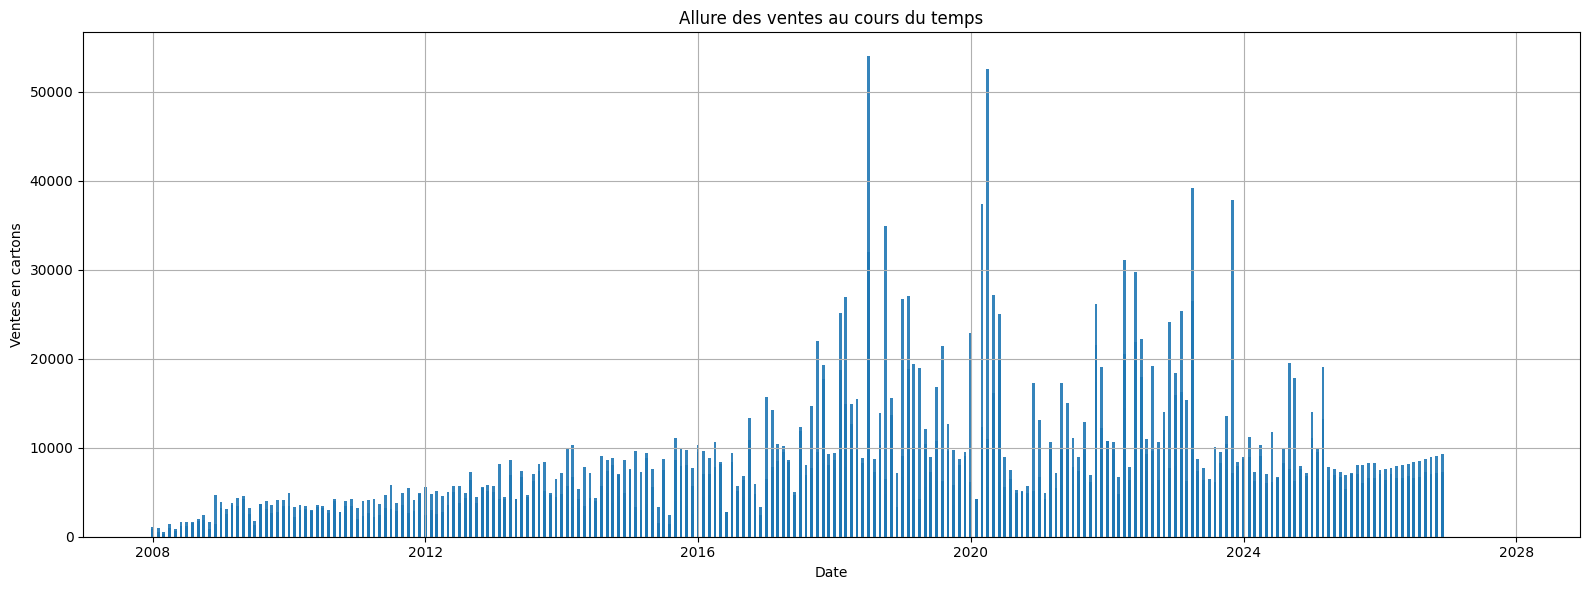

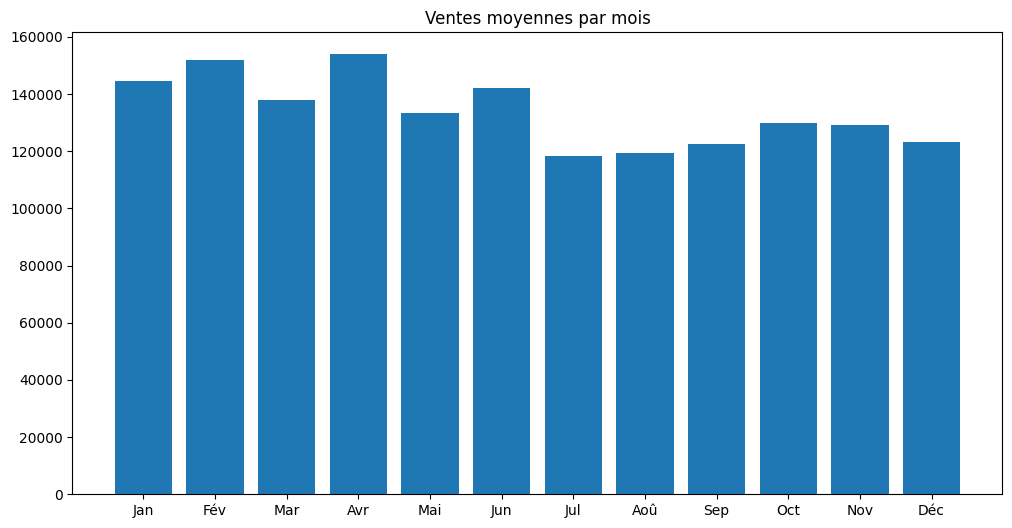

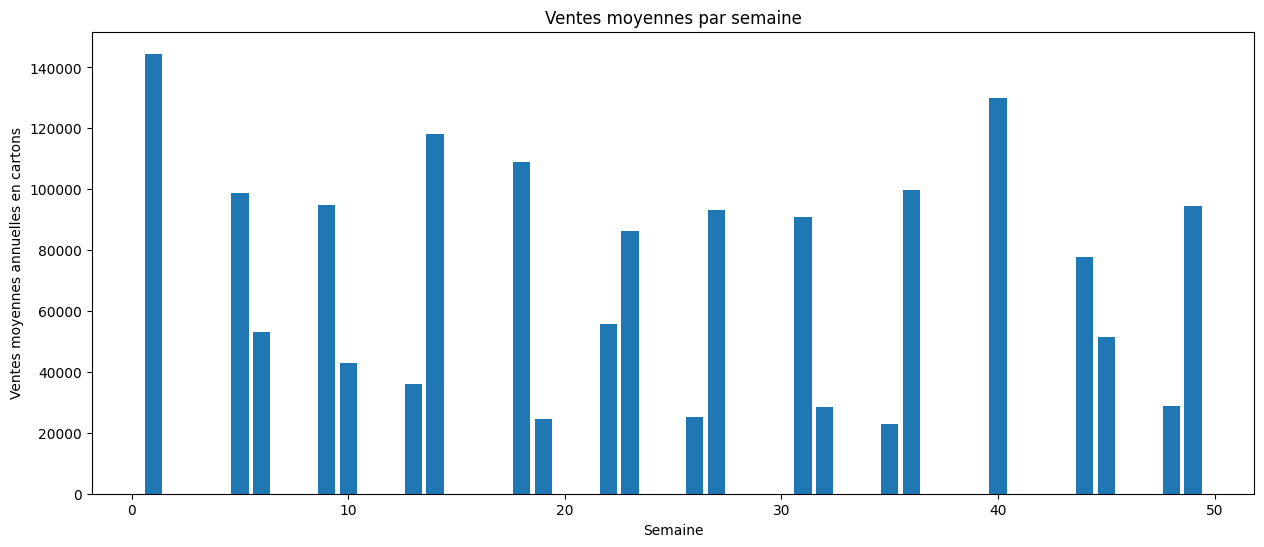

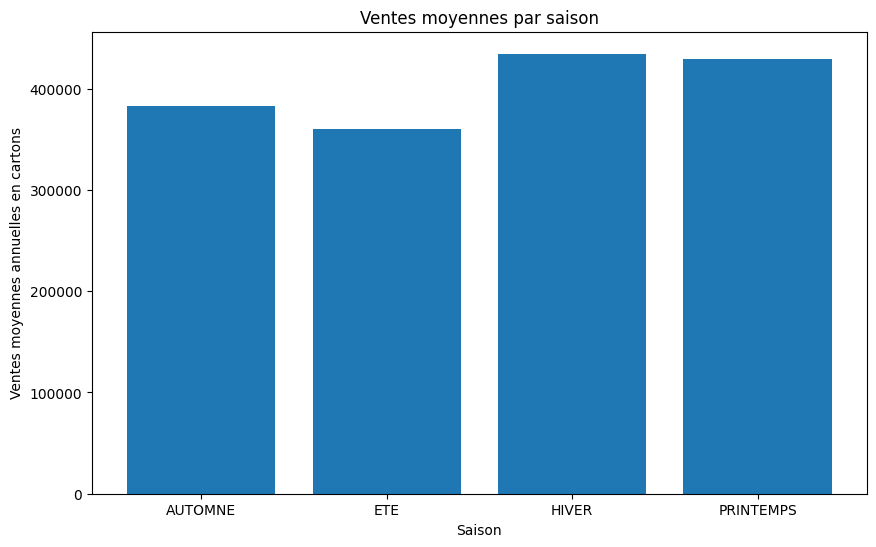

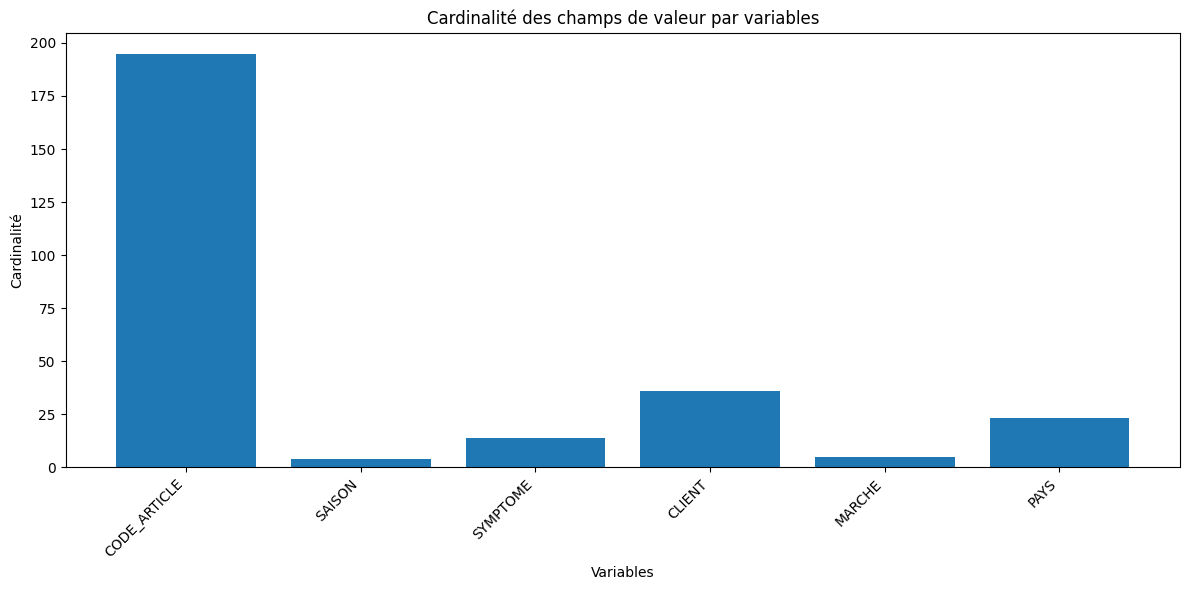

In [5]:
plt.figure(figsize=(16, 6))
plt.bar(df['DATE'], df['VENTES'], alpha=0.9, width=15)
plt.title("Allure des ventes au cours du temps")
plt.xlabel("Date")
plt.ylabel("Ventes en cartons")
plt.grid(True)
plt.tight_layout()
plt.show()

annee_debut=2022
nb_annees=np.max(df['ANNEE'].unique()) - annee_debut + 1

moyennes_mois=[np.sum(df['VENTES'][(df['MOIS'] == m) & (df['ANNEE'] >= annee_debut)]) / nb_annees 
                 for m in range(1, 13)]

plt.figure(figsize=(12, 6))
plt.bar(range(1, 13), moyennes_mois)
plt.title('Ventes moyennes par mois')
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])

semaines_uniques=sorted(df['SEMAINE'].unique())
moyennes_semaine=[np.sum(df['VENTES'][(df['SEMAINE'] == s) & (df['ANNEE'] >= annee_debut)]) / nb_annees 
                    for s in semaines_uniques]

plt.figure(figsize=(15, 6))
plt.bar(semaines_uniques, moyennes_semaine)
plt.title('Ventes moyennes par semaine')
plt.xlabel('Semaine')
plt.ylabel('Ventes moyennes annuelles en cartons')

saisons_uniques=sorted(df['SAISON'].unique())
moyennes_saison=[np.sum(df['VENTES'][(df['SAISON'] == s) & (df['ANNEE'] >= annee_debut)]) / nb_annees 
                   for s in saisons_uniques]

plt.figure(figsize=(10, 6))
plt.bar(saisons_uniques, moyennes_saison)
plt.title('Ventes moyennes par saison')
plt.xlabel('Saison')
plt.ylabel('Ventes moyennes annuelles en cartons')

# Cardinalité des variables (reste identique)
CODE_ART=len(df['CODE_ARTICLE'].unique())
SAISON=len(df['SAISON'].unique())
SYMPTOMS=len(df['SYMPTOME'].unique())
CLIENT=len(df['CLIENT'].unique())
MARCHE=len(df['MARCHE'].unique())
PAYS=len(df['PAYS'].unique())

to_encode=pd.DataFrame({
    'Variable': ['CODE_ARTICLE', 'SAISON', 'SYMPTOME', 'CLIENT', 'MARCHE', 'PAYS'],
    'Modalités_uniques': [CODE_ART, SAISON, SYMPTOMS, CLIENT, MARCHE, PAYS]
})

plt.figure(figsize=(12, 6))
plt.bar(range(len(to_encode)), to_encode['Modalités_uniques'])
plt.title('Cardinalité des champs de valeur par variables')
plt.xlabel('Variables')
plt.ylabel('Cardinalité')
plt.xticks(range(len(to_encode)), to_encode['Variable'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

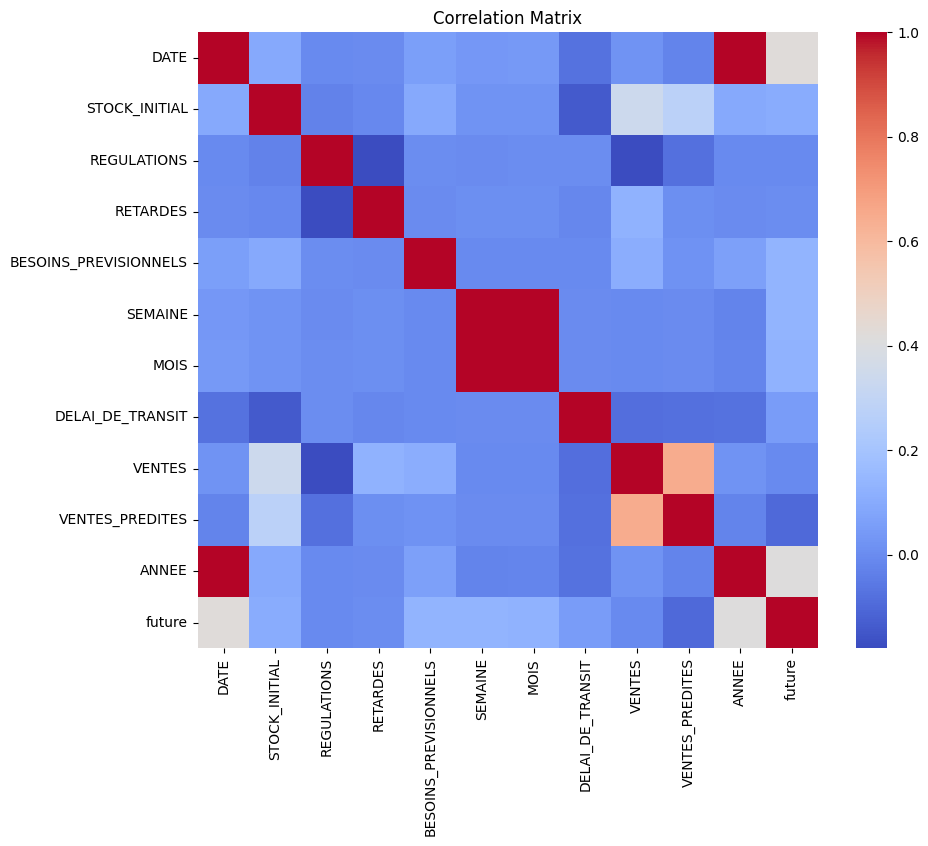

VENTES                   1.000000
VENTES_PREDITES          0.646901
STOCK_INITIAL            0.339659
RETARDES                 0.125819
BESOINS_PREVISIONNELS    0.107655
ANNEE                    0.019469
DATE                     0.019040
future                  -0.005153
MOIS                    -0.006861
SEMAINE                 -0.007131
DELAI_DE_TRANSIT        -0.083889
REGULATIONS             -0.174692
Name: VENTES, dtype: float64


In [6]:
correlation_matrix=df.drop(['CODE_ARTICLE','CLIENT','MARCHE','PAYS','SYMPTOME','CODE_ISO','SAISON'],axis=1).corr()
VENTES_correlation=correlation_matrix['VENTES'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Displaying the correlation with VENTES
print(VENTES_correlation)
df=df.copy()

# Traitement des variables catégorielles et feature selection

Vu les différences de cardinalité entre les variables catégorielles, nous allons procéder à trois types d'encoding. Target encoding pour la variable CODE_ARTICLE, et une selon les quartiles des observations des variables CLIENT, PAYS, SYMPTOME. Pour le marché et les saisons, nous allons procéder à un one-hot encoding classique.

On commence alors par le calcul des quartiles pour les trois variables citées.

In [7]:
#####################################################PAR CLIENT
df['DATE']=pd.to_datetime(df['DATE'])
df['ANNEE']=df['DATE'].dt.year
df_recent=df[(df['ANNEE'] >= 2022) & (df['ANNEE'] <= 2023)].copy()

# Calculer les ventes totales par client et par année
ventes_annuelles=df_recent.groupby(['CLIENT', 'ANNEE'])['VENTES'].sum().reset_index()

# Calculer la moyenne des ventes annuelles par client depuis 2022
moyenne_ventes_client=ventes_annuelles.groupby('CLIENT')['VENTES'].mean().reset_index()
moyenne_ventes_client.columns=['CLIENT', 'MOYENNE_VENTES_ANNUELLES_CLIENT']

print(f"Nombre de clients : {len(moyenne_ventes_client)}")
print(f"Statistiques descriptives:")
print(moyenne_ventes_client['MOYENNE_VENTES_ANNUELLES_CLIENT'].describe())

#####################################################PAR SYMPTOMES

# Calculer les ventes totales par symptôme et par année
ventes_annuelles=df_recent.groupby(['SYMPTOME', 'ANNEE'])['VENTES'].sum().reset_index()

# Calculer la moyenne des ventes annuelles par symptôme depuis 2022
moyenne_ventes_symptoms=ventes_annuelles.groupby('SYMPTOME')['VENTES'].mean().reset_index()
moyenne_ventes_symptoms.columns=['SYMPTOME', 'MOYENNE_VENTES_ANNUELLES_SYMPTOME']

print(f"Nombre de symtômes: {len(moyenne_ventes_symptoms)}")
print(f"Statistiques descriptives:")
print(moyenne_ventes_symptoms['MOYENNE_VENTES_ANNUELLES_SYMPTOME'].describe())

#####################################################PAR PAYS

# Calculer les ventes totales par pays et par année
ventes_annuelles=df_recent.groupby(['PAYS', 'ANNEE'])['VENTES'].sum().reset_index()

# Calculer la moyenne des ventes annuelles par pays depuis 2022
moyenne_ventes_pays=ventes_annuelles.groupby('PAYS')['VENTES'].mean().reset_index()
moyenne_ventes_pays.columns=['PAYS', 'MOYENNE_VENTES_ANNUELLES_PAYS']

print(f"Nombre de pays : {len(moyenne_ventes_pays)}")
print(f"Statistiques descriptives:")
print(moyenne_ventes_pays['MOYENNE_VENTES_ANNUELLES_PAYS'].describe())

Nombre de clients : 28
Statistiques descriptives:
count        28.000000
mean      77997.410714
std      120397.031702
min         315.500000
25%       19766.625000
50%       34147.750000
75%       56900.125000
max      514958.000000
Name: MOYENNE_VENTES_ANNUELLES_CLIENT, dtype: float64
Nombre de symtômes: 14
Statistiques descriptives:
count        14.000000
mean     155994.821429
std      226947.974816
min           0.000000
25%       15889.375000
50%       80763.250000
75%      188943.250000
max      854231.500000
Name: MOYENNE_VENTES_ANNUELLES_SYMPTOME, dtype: float64
Nombre de pays : 23
Statistiques descriptives:
count        23.000000
mean      94953.369565
std      143189.193366
min        1257.000000
25%        8495.000000
50%       30015.000000
75%      102068.250000
max      555782.500000
Name: MOYENNE_VENTES_ANNUELLES_PAYS, dtype: float64


On les classifie selon les quartiles obtenus

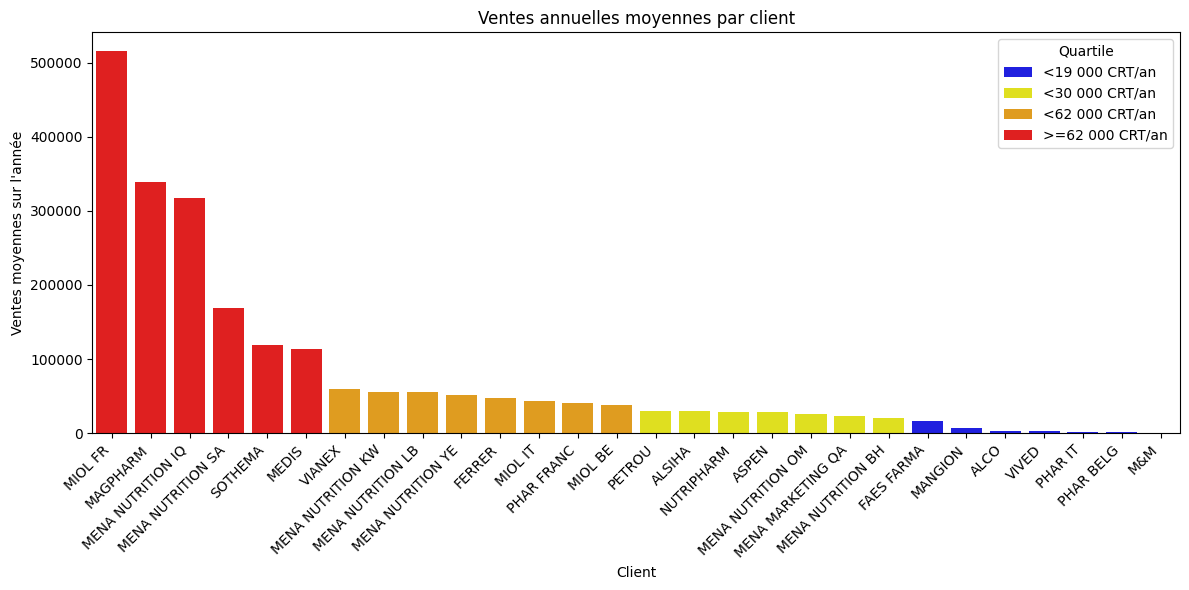

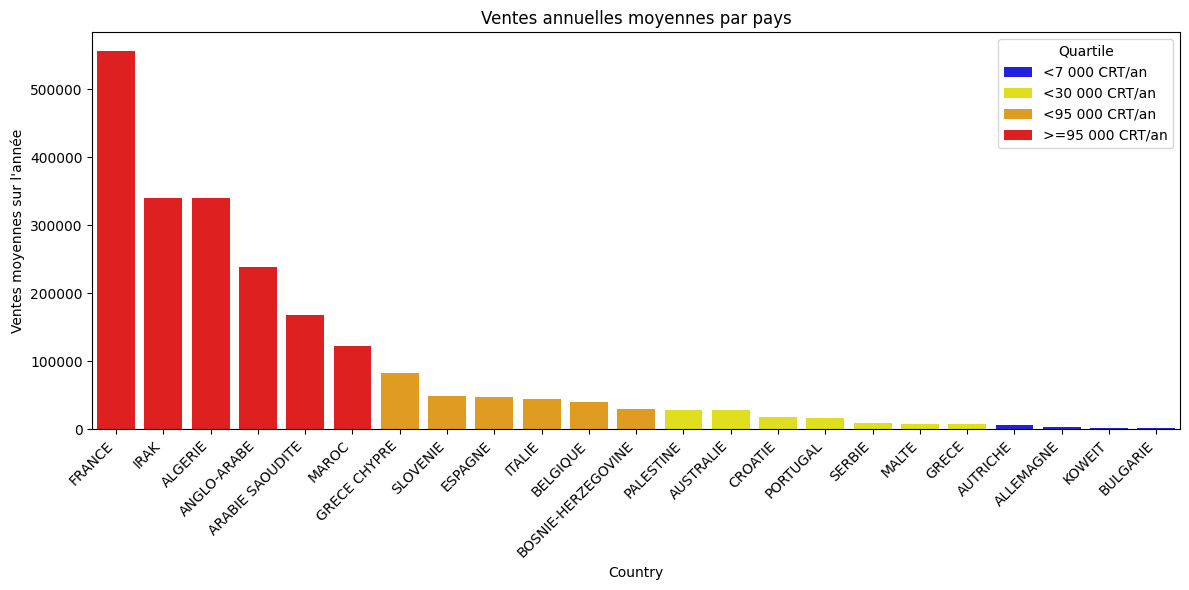

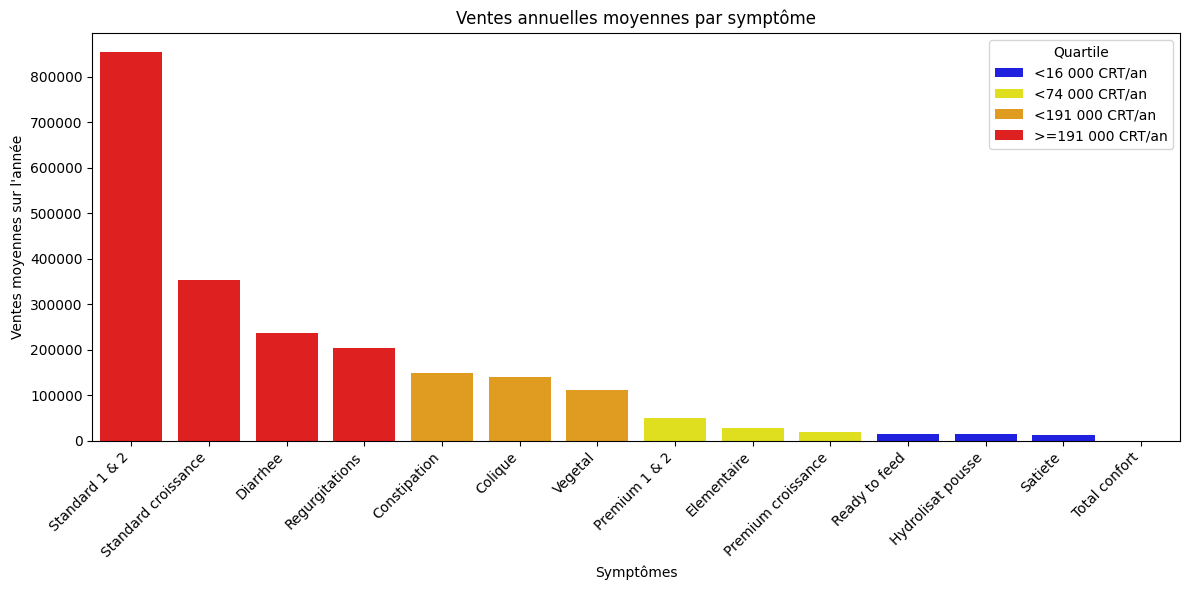

In [8]:
# CLIENTS - Seuils personnalisés
customer_VENTES=moyenne_ventes_client.sort_values(
    by='MOYENNE_VENTES_ANNUELLES_CLIENT', ascending=False
).copy()

customer_VENTES['quartile']=pd.cut(
    customer_VENTES['MOYENNE_VENTES_ANNUELLES_CLIENT'],
    bins=[0, 19000, 30000, 62000, float('inf')],
    labels=['<19 000 CRT/an', '<30 000 CRT/an', '<62 000 CRT/an', '>=62 000 CRT/an'],
    include_lowest=True
)

palette={
    '<19 000 CRT/an': 'blue',
    '<30 000 CRT/an': 'yellow', 
    '<62 000 CRT/an': 'orange',
    '>=62 000 CRT/an': 'red'
}

plt.figure(figsize=(12, 6))
sns.barplot(
    x='CLIENT',
    y='MOYENNE_VENTES_ANNUELLES_CLIENT',
    hue='quartile',
    dodge=False,
    data=customer_VENTES,
    palette=palette
)
plt.title('Ventes annuelles moyennes par client')
plt.xlabel('Client')
plt.ylabel("Ventes moyennes sur l'année")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Quartile")
plt.tight_layout()
plt.show()

# PAYS - Seuils personnalisés
country_VENTES=moyenne_ventes_pays.sort_values(
    by='MOYENNE_VENTES_ANNUELLES_PAYS', ascending=False
).copy()

country_VENTES['quartile']=pd.cut(
    country_VENTES['MOYENNE_VENTES_ANNUELLES_PAYS'],
    bins=[0, 7000, 30000, 95000, float('inf')],
    labels=['<7 000 CRT/an', '<30 000 CRT/an', '<95 000 CRT/an', '>=95 000 CRT/an'],
    include_lowest=True
)

palette={
    '<7 000 CRT/an': 'blue',
    '<30 000 CRT/an': 'yellow',
    '<95 000 CRT/an': 'orange', 
    '>=95 000 CRT/an': 'red'
}

plt.figure(figsize=(12, 6))
sns.barplot(
    x='PAYS',
    y='MOYENNE_VENTES_ANNUELLES_PAYS',
    hue='quartile',
    dodge=False,
    data=country_VENTES,
    palette=palette
)
plt.title('Ventes annuelles moyennes par pays')
plt.xlabel('Country')
plt.ylabel("Ventes moyennes sur l'année")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Quartile")
plt.tight_layout()
plt.show()

# SYMPTOMES - Seuils personnalisés
symptoms_VENTES=moyenne_ventes_symptoms.sort_values(
    by='MOYENNE_VENTES_ANNUELLES_SYMPTOME', ascending=False
).copy()

symptoms_VENTES['quartile']=pd.cut(
    symptoms_VENTES['MOYENNE_VENTES_ANNUELLES_SYMPTOME'],
    bins=[0, 16000, 74000, 191000, float('inf')],
    labels=['<16 000 CRT/an', '<74 000 CRT/an', '<191 000 CRT/an', '>=191 000 CRT/an'],
    include_lowest=True
)

palette={
    '<16 000 CRT/an': 'blue',
    '<74 000 CRT/an': 'yellow',
    '<191 000 CRT/an': 'orange',
    '>=191 000 CRT/an': 'red'
}

plt.figure(figsize=(12, 6))
sns.barplot(
    x='SYMPTOME',
    y='MOYENNE_VENTES_ANNUELLES_SYMPTOME',
    hue='quartile',
    dodge=False,
    data=symptoms_VENTES,
    palette=palette
)
plt.title('Ventes annuelles moyennes par symptôme')
plt.xlabel('Symptômes')
plt.ylabel("Ventes moyennes sur l'année")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Quartile")
plt.tight_layout()
plt.show()

In [9]:
client_V=df.groupby('CLIENT')['VENTES'].sum() / df['DATE'].nunique() * 12
CLIENT_CATEGORY= pd.cut(client_V, 
                               bins=[0, 19000, 30000, 62000, float('inf')],
                               labels=['Small', 'Medium', 'Large', 'VeryLarge'])
CLIENT_CATEGORY=pd.DataFrame({ 'CLIENT': np.sort(df['CLIENT'].unique()),
                'CLIENT_CATEGORY': CLIENT_CATEGORY
              }).reset_index(drop=True)

symptom_V=df.groupby('SYMPTOME')['VENTES'].sum() / df['DATE'].nunique() * 12
SYMPTOM_CATEGORY= pd.cut(symptom_V, 
                               bins=[0, 16000, 74000, 191000, float('inf')],
                               labels=['Small', 'Medium', 'Large', 'VeryLarge'])
SYMPTOM_CATEGORY=pd.DataFrame({ 'SYMPTOME': np.sort(df['SYMPTOME'].unique()),
                'SYMPTOM_CATEGORY': SYMPTOM_CATEGORY
              }).reset_index(drop=True)

country_V=df.groupby('PAYS')['VENTES'].sum() / df['DATE'].nunique() * 12
COUNTRY_CATEGORY= pd.cut(country_V, 
                                 bins=[0, 7000, 30000, 95000, float('inf')],
                                 labels=['Small', 'Medium', 'Large', 'VeryLarge'])
COUNTRY_CATEGORY=pd.DataFrame({ 'PAYS': np.sort(df['PAYS'].unique()),
                'COUNTRY_CATEGORY': COUNTRY_CATEGORY
              }).reset_index(drop=True)

df_merged=pd.merge(
    df,           
    CLIENT_CATEGORY[['CLIENT', 'CLIENT_CATEGORY']],  # On ne garde que CLIENT et CATEGORY pour éviter les doublons inutiles
    on='CLIENT',
    how='left'     
)

df_merged=pd.merge(
    df_merged,          
    SYMPTOM_CATEGORY[['SYMPTOME', 'SYMPTOM_CATEGORY']], 
    on='SYMPTOME', 
    how='left'    
)

df_merged=pd.merge(
    df_merged,          
    COUNTRY_CATEGORY[['PAYS', 'COUNTRY_CATEGORY']],  
    on='PAYS',  
    how='left'     
)

df=df_merged.copy()
df=df.sort_values(by=['CLIENT', 'CODE_ARTICLE', 'DATE'])


Target encoding de notre variable CODE_ARTICLE

In [10]:
encoding=target_encoding_cv(
    df, 
    categorical_col='CODE_ARTICLE', 
    target_col='VENTES',
    n_splits=5,
    smoothing=1.0
)

df['CODE_ART_encoded_cv']=encoding[0]
code_to_decode=encoding[1]
encoded_to_code=encoding[2]

df_og=df.copy()
art_cols=[col for col in df.columns if col.startswith("CODE_ART")]
df[art_cols]

,CODE_ARTICLE,CODE_ART_encoded_cv
3752,AC1-400-MA,334.486816
3755,AC1-400-MA,334.486816
3760,AC1-400-MA,338.462004
3761,AC1-400-MA,346.004861
3765,AC1-400-MA,320.837084
...,...,...
41497,N2-800S-DE,28.602826
41498,N2-800S-DE,28.602826
41499,N2-800S-DE,29.039352
41500,N2-800S-DE,25.936160


Changement de nos variables MOIS, SEMAINE en variable cycliques à l'aide des fonction 2$\pi$ périodiques cosinus et sinus.

In [11]:
df['year']=df['DATE'].dt.year
df['month_sin']=np.sin(2 * np.pi * df['MOIS'] / 12)
df['month_cos']=np.cos(2 * np.pi * df['MOIS'] / 12)
df['week_sin']=np.sin(2 * np.pi * df['SEMAINE'] / 52)
df['week_cos']=np.cos(2 * np.pi * df['SEMAINE'] / 52)
df=df.drop(columns=['DATE', 'SEMAINE'])
df.head()

,CODE_ARTICLE,STOCK_INITIAL,REGULATIONS,RETARDES,BESOINS_PREVISIONNELS,MARCHE,CLIENT,CODE_ISO,PAYS,MOIS,...,future,CLIENT_CATEGORY,SYMPTOM_CATEGORY,COUNTRY_CATEGORY,CODE_ART_encoded_cv,year,month_sin,month_cos,week_sin,week_cos
3752,AC1-400-MA,0,0,0,0,UPM,ALCO,MA,MAROC,1,...,0,Small,Medium,Large,334.486816,2022,0.500000,8.660254e-01,0.120537,0.992709
3755,AC1-400-MA,0,0,0,0,UPM,ALCO,MA,MAROC,2,...,0,Small,Medium,Large,334.486816,2022,0.866025,5.000000e-01,0.663123,0.748511
3760,AC1-400-MA,0,0,0,0,UPM,ALCO,MA,MAROC,3,...,0,Small,Medium,Large,338.462004,2022,1.000000,6.123234e-17,0.935016,0.354605
3761,AC1-400-MA,0,0,0,0,UPM,ALCO,MA,MAROC,4,...,0,Small,Medium,Large,346.004861,2022,0.866025,-5.000000e-01,0.992709,-0.120537
3765,AC1-400-MA,0,0,0,0,UPM,ALCO,MA,MAROC,5,...,0,Small,Medium,Large,320.837084,2022,0.500000,-8.660254e-01,0.748511,-0.663123


In [12]:
#One hot encoding des variables catégorielles restants
categorical_cols=['MARCHE','SAISON','COUNTRY_CATEGORY','CLIENT_CATEGORY','SYMPTOM_CATEGORY']
df=pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df=df.drop(['ANNEE','CODE_ISO','CLIENT','PAYS','SYMPTOME'],axis=1)

Visualisation de la distribution des ventes

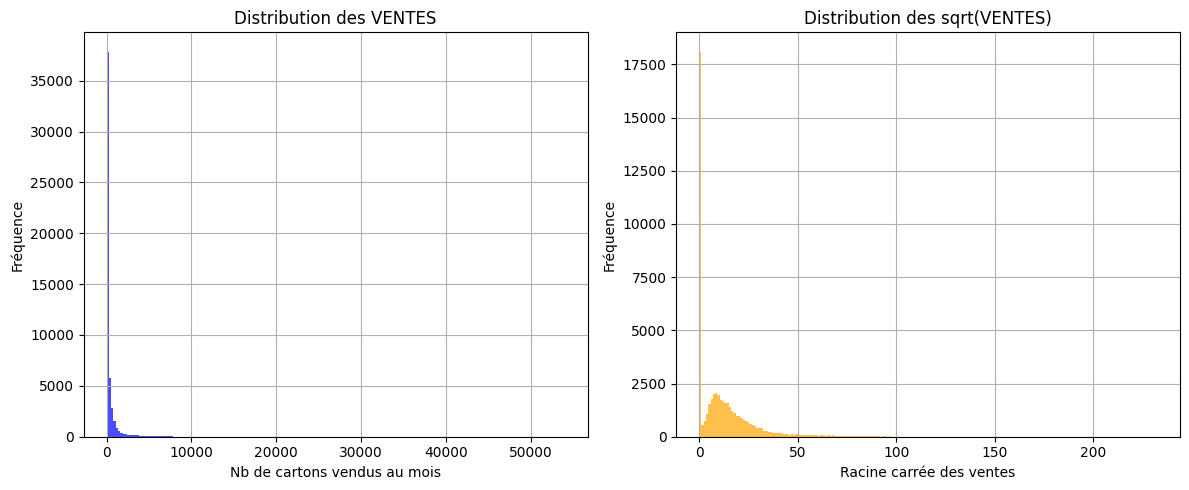

count    52233.000000
mean       406.361094
std       1261.558498
min          0.000000
25%          0.000000
50%         70.000000
75%        313.000000
max      53967.000000
Name: VENTES, dtype: float64

In [13]:
plt.figure(figsize=(12, 5))

# 1er subplot : VENTES
plt.subplot(1, 2, 1)
plt.hist(df['VENTES'], bins=200, alpha=0.7, color='blue')
plt.title("Distribution des VENTES")
plt.xlabel("Nb de cartons vendus au mois")
plt.ylabel("Fréquence")
plt.grid(True)

# 2ème subplot : sqrt(VENTES)
plt.subplot(1, 2, 2)
plt.hist(np.sqrt(df['VENTES']), bins=200, alpha=0.7, color='orange')
plt.title("Distribution des sqrt(VENTES)")
plt.xlabel("Racine carrée des ventes")
plt.ylabel("Fréquence")
plt.grid(True)

plt.tight_layout()
plt.show()

df['VENTES'].describe()


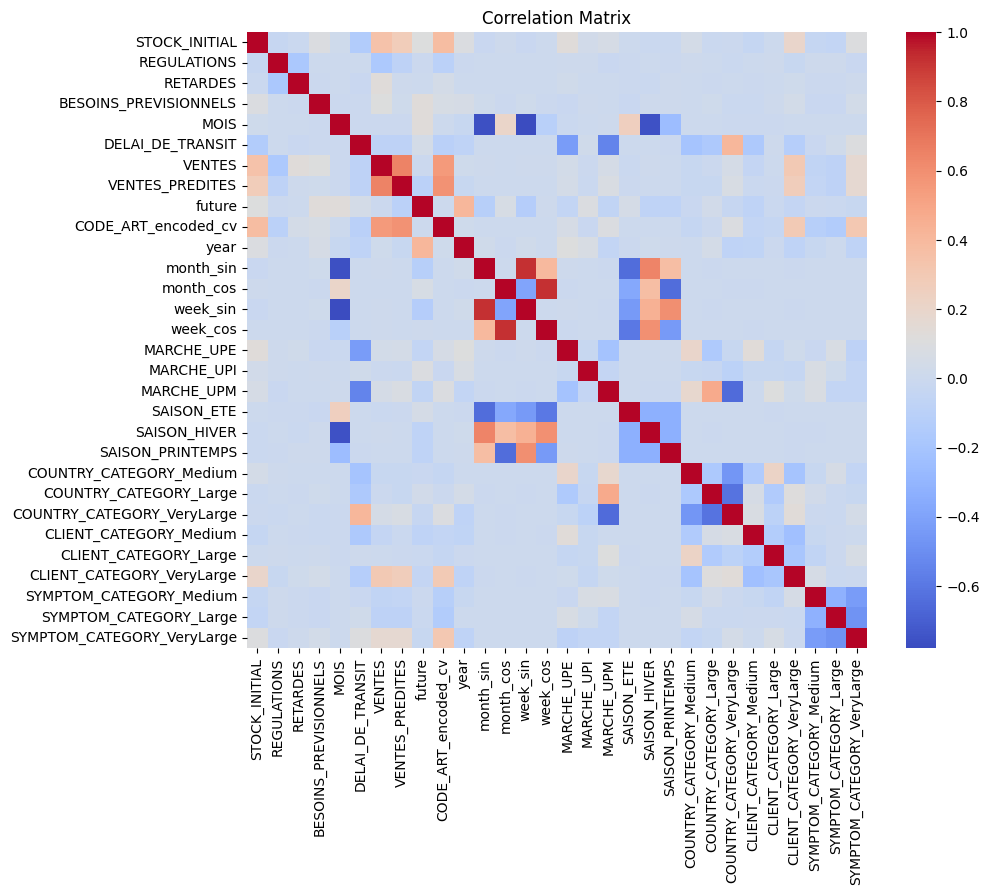

VENTES                        1.000000
VENTES_PREDITES               0.646901
CODE_ART_encoded_cv           0.548231
STOCK_INITIAL                 0.339659
CLIENT_CATEGORY_VeryLarge     0.302488
SYMPTOM_CATEGORY_VeryLarge    0.171808
RETARDES                      0.125819
BESOINS_PREVISIONNELS         0.107655
MARCHE_UPM                    0.052500
COUNTRY_CATEGORY_VeryLarge    0.051682
MARCHE_UPE                    0.040060
year                          0.019469
month_sin                     0.010626
week_cos                      0.009747
SAISON_HIVER                  0.007959
week_sin                      0.007318
month_cos                     0.005540
SAISON_PRINTEMPS              0.001833
CLIENT_CATEGORY_Large        -0.000586
COUNTRY_CATEGORY_Large       -0.003795
future                       -0.005153
MOIS                         -0.006861
MARCHE_UPI                   -0.007408
SAISON_ETE                   -0.009484
COUNTRY_CATEGORY_Medium      -0.022535
CLIENT_CATEGORY_Medium   

In [14]:
#Matrice de corrélation finale
correlation_matrix=df.drop('CODE_ARTICLE',axis=1).corr()
VENTES_correlation=correlation_matrix['VENTES'].sort_values(ascending=False)
correlation_matrix=df.drop('CODE_ARTICLE',axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

print(VENTES_correlation)
df=df.copy()

Début des prédictions en commençant par la baseline. Pour les modèles de régression linéaire simples avec ou sans pénalité, il est nécessaire de normaliser les données. 

In [15]:
df_future = df[df['year']>=2025] #train/test = Après/2024
df = df[df['year']<2025] #train/test = Avant/2024

In [16]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
# #Construction des sous ensemble train et test.
X=df.drop(columns=['VENTES','CODE_ARTICLE','future'])

#Normalisation
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y=df['VENTES']

train_mask=df['year'] < 2024
test_mask=df['year'] >= 2024

X_train=X[train_mask].drop(columns=['VENTES_PREDITES'])
X_test=X[test_mask].drop(columns=['VENTES_PREDITES'])
y_train=y[train_mask]
y_test=y[test_mask]
forecast_train=X[train_mask]['VENTES_PREDITES']
forecast_test=X[test_mask]['VENTES_PREDITES']

#recherche des hyperparamètres optimaux 
best_models=best_lasso_ridge(X_train, y_train, X_test, y_test)

c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+10, tolerance: 6.792e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e+10, tolerance: 6.792e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

In [17]:
##############################################Linear Regression model ##########################################################
lin_model=LinearRegression()
lin_model.fit(X_train, y_train)


y_pred_lin=pd.Series(lin_model.predict(X_test), index=y_test.index)
y_pred_linT=pd.Series(lin_model.predict(X_train), index=y_train.index)

# Evaluation des performances sur le sous-ensemble test
rmse_lin=np.sqrt(mean_squared_error(y_test, y_pred_lin))
mae_lin=mean_absolute_error(y_test, y_pred_lin)
r2_lin=r2_score(y_test, y_pred_lin)

# Evaluation des performances sur le sous-ensemble train
rmse_linT=np.sqrt(mean_squared_error(y_train, y_pred_linT))
mae_linT=mean_absolute_error(y_train, y_pred_linT)
r2_linT=r2_score(y_train, y_pred_linT)

##############################################Lasso Regression model ##########################################################

lasso_model=best_models['Lasso']['model']
lasso_model.fit(X_train, y_train)

y_pred_lasso=pd.Series(lasso_model.predict(X_test), index=y_test.index)
y_pred_lassoT=pd.Series(lasso_model.predict(X_train), index=y_train.index)

rmse_lasso=np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso=mean_absolute_error(y_test, y_pred_lasso)
r2_lasso=r2_score(y_test, y_pred_lasso)

rmse_lassoT=np.sqrt(mean_squared_error(y_train, y_pred_lassoT))
mae_lassoT=mean_absolute_error(y_train, y_pred_lassoT)
r2_lassoT=r2_score(y_train, y_pred_lassoT)


##############################################Ridge Regression model ##########################################################

ridge_model=best_models['Ridge']['model']
ridge_model.fit(X_train, y_train)

y_pred_ridge=pd.Series(ridge_model.predict(X_test), index=y_test.index)
y_pred_ridgeT=pd.Series(ridge_model.predict(X_train), index=y_train.index)

rmse_ridge=np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge=mean_absolute_error(y_test, y_pred_ridge)
r2_ridge=r2_score(y_test, y_pred_ridge)

rmse_ridgeT=np.sqrt(mean_squared_error(y_train, y_pred_ridgeT))
mae_ridgeT=mean_absolute_error(y_train, y_pred_ridgeT)
r2_ridgeT=r2_score(y_train, y_pred_ridgeT)

##############################################Prédictions manuelles##########################################################


rmse_fm=np.sqrt(mean_squared_error(y_test, forecast_test))
mae_fm=mean_absolute_error(y_test, forecast_test)
r2_fm=r2_score(y_test, forecast_test) 


rmse_fmT=np.sqrt(mean_squared_error(y_train, forecast_train))
mae_fmT=mean_absolute_error(y_train, forecast_train)
r2_fmT=r2_score(y_train, forecast_train) 

#Collecte des métriques de performance pour l'affichage (test)
performance_metricsR={
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Forecast Manuel'],
    'RMSE': [rmse_lin, rmse_ridge, rmse_lasso, rmse_fm],
    'MAE': [mae_lin, mae_ridge, mae_lasso, mae_fm],
    'R2': [r2_lin, r2_ridge, r2_lasso, r2_fm],
}

# Collecte des métriques de performance pour l'affichage (train)
performance_metricsTR={
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Forecast Manuel'],
    'RMSE': [rmse_linT, rmse_ridgeT, rmse_lassoT, rmse_fmT],
    'MAE': [mae_linT, mae_ridgeT, mae_lassoT, mae_fmT],
    'R2': [r2_linT, r2_ridgeT, r2_lassoT, r2_fmT],
}

performance_dfR=pd.DataFrame(performance_metricsR)
performance_dfTR=pd.DataFrame(performance_metricsTR)

print("\n=== Métriques sur les données de test ===")
print(performance_dfR)
print("\n=== Métriques sur les données de train ===")
print(performance_dfTR)



=== Métriques sur les données de test ===
               Model         RMSE         MAE        R2
0  Linear Regression   736.397726  372.960465  0.598402
1   Ridge Regression   735.616808  372.326766  0.599253
2   Lasso Regression   714.420942  361.333107  0.622015
3    Forecast Manuel  1251.055224  465.721514 -0.159097

=== Métriques sur les données de train ===
               Model         RMSE         MAE        R2
0  Linear Regression  1023.297239  365.190918  0.386971
1   Ridge Regression  1023.364758  364.750893  0.386890
2   Lasso Regression  1024.583386  358.912558  0.385429
3    Forecast Manuel  1366.526340  401.313307 -0.093235


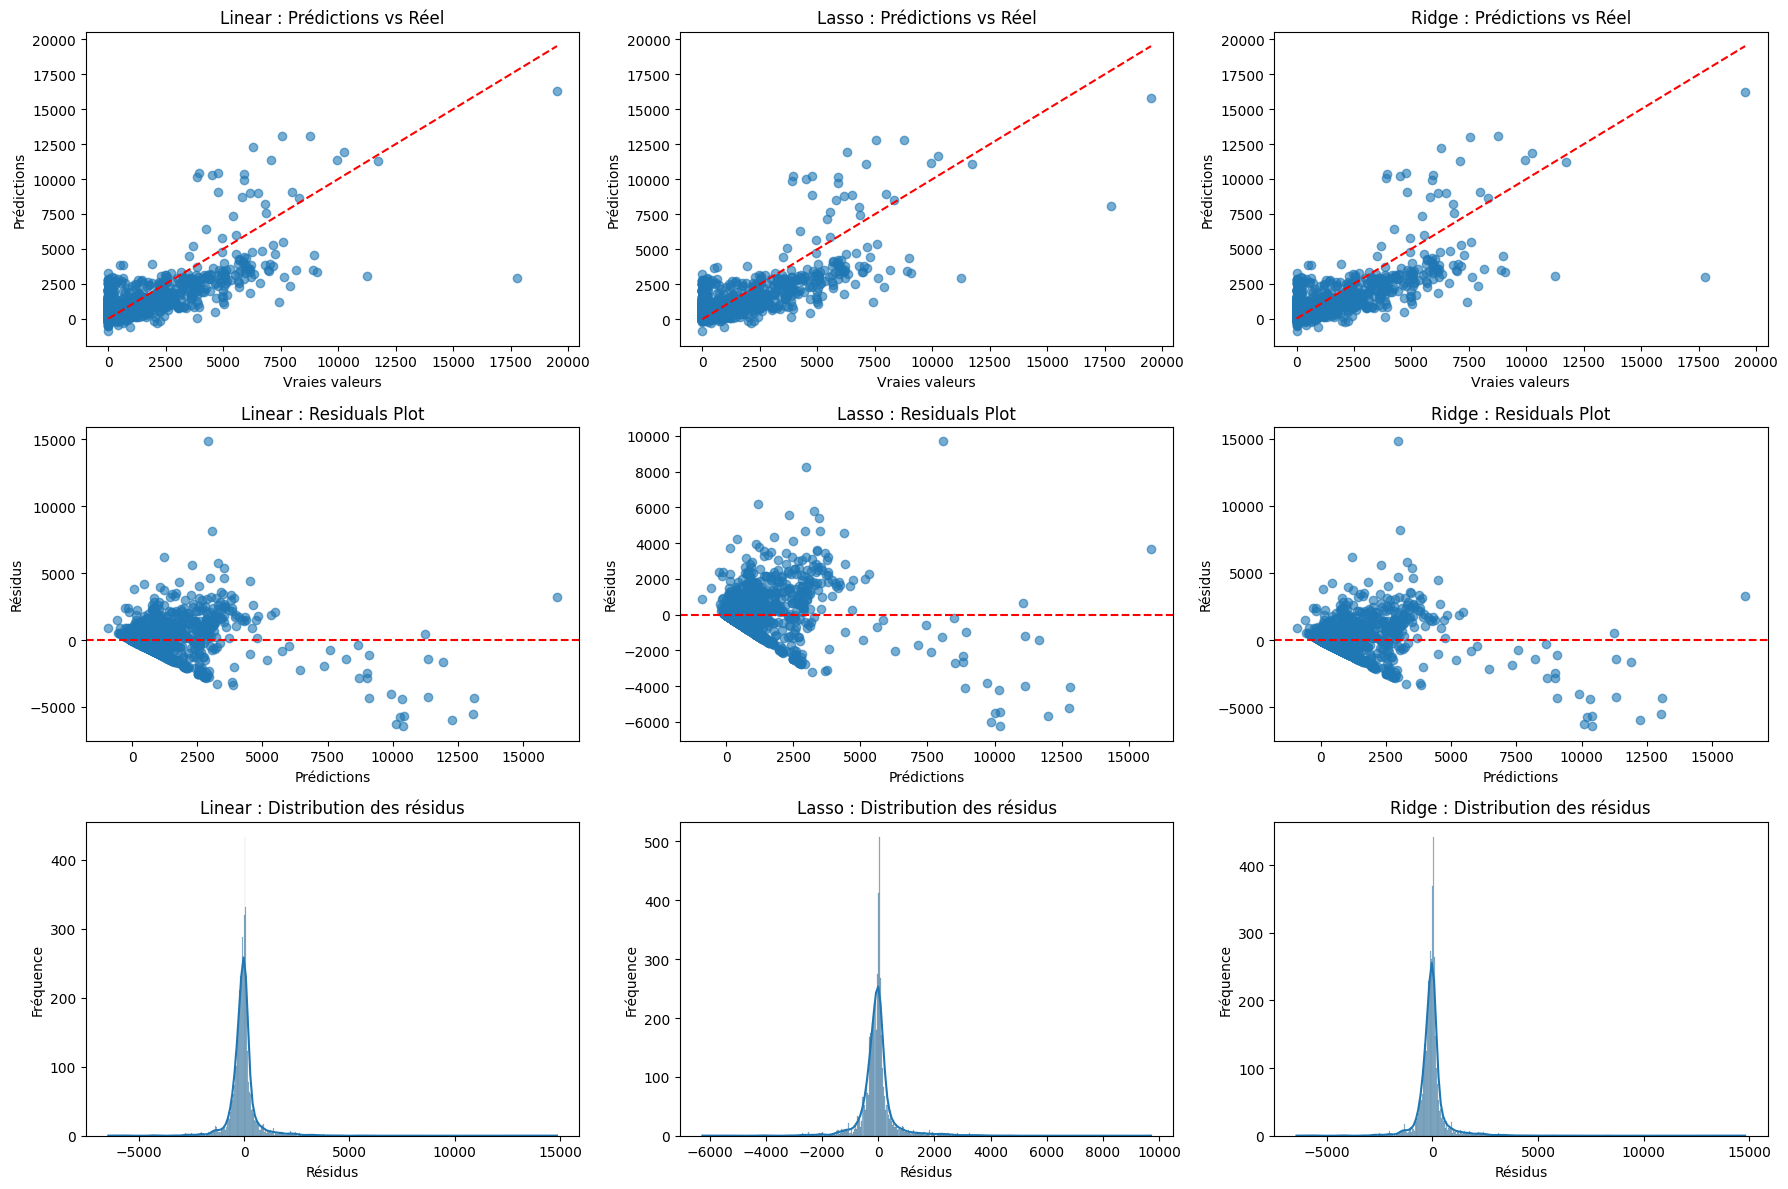

In [18]:
# Dictionnaire des modèles et leurs prédictions
predictions={
    'Linear': y_pred_lin,
    'Lasso': y_pred_lasso,
    'Ridge': y_pred_ridge
}

fig, axes=plt.subplots(3, 3, figsize=(18, 12))

for col, (name, y_pred) in enumerate(predictions.items()):
    residuals=y_test - y_pred

    # 1ère ligne : scatter prédictions vs vrai + diagonale
    axes[0, col].scatter(y_test, y_pred, alpha=0.6)
    axes[0, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, col].set_title(f"{name} : Prédictions vs Réel")
    axes[0, col].set_xlabel("Vraies valeurs")
    axes[0, col].set_ylabel("Prédictions")

    # 2ème ligne : residuals plot
    axes[1, col].scatter(y_pred, residuals, alpha=0.6)
    axes[1, col].axhline(0, color='r', linestyle='--')
    axes[1, col].set_title(f"{name} : Residuals Plot")
    axes[1, col].set_xlabel("Prédictions")
    axes[1, col].set_ylabel("Résidus")

    # 3ème ligne : distribution des résidus
    sns.histplot(residuals, kde=True, ax=axes[2, col])
    axes[2, col].set_title(f"{name} : Distribution des résidus")
    axes[2, col].set_xlabel("Résidus")
    axes[2, col].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

In [19]:
#Préparations des sous-ensembles train et test pour l'entraînement et le test des modèles de types ensemble d'arbres (on drop la normalisation)
X=df.drop(columns=['VENTES','CODE_ARTICLE','future'])
y=df['VENTES']

# Splitting the data into training and testing sets (temporal split before/after 2024)
train_mask=df['year'] < 2024
test_mask=df['year'] >= 2024

X_train=X[train_mask].drop(columns=['VENTES_PREDITES'])
X_test=X[test_mask].drop(columns=['VENTES_PREDITES'])
y_train=y[train_mask]
y_test=y[test_mask]
forecast_train=X[train_mask]['VENTES_PREDITES']
forecast_test=X[test_mask]['VENTES_PREDITES']

In [20]:
##############################################RandomForest model##########################################################

rf_model=RandomForestRegressor()
rf_model.fit(X_train, y_train)
# Résultats du GridSearch{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
# Making predictions
y_pred_rf= pd.Series(rf_model.predict(X_test), index=y_test.index)
y_pred_rfT=pd.Series(rf_model.predict(X_train), index=y_train.index)


rmse_rf=np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf=mean_absolute_error(y_test, y_pred_rf)
r2_rf=r2_score(y_test, y_pred_rf) 



rmse_rfT=np.sqrt(mean_squared_error(y_train, y_pred_rfT))
mae_rfT=mean_absolute_error(y_train, y_pred_rfT)
r2_rfT=r2_score(y_train, y_pred_rfT) 


##############################################XGBoost model ##########################################################

xg_model=xgb.XGBRegressor()
xg_model.fit(X_train, y_train)
# Résultat de la GridSearch{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# Making predictions
y_pred_xg=pd.Series(xg_model.predict(X_test), index=y_test.index)
y_pred_xgT=pd.Series(xg_model.predict(X_train), index=y_train.index)


rmse_xg=np.sqrt(mean_squared_error(y_test, y_pred_xg))
mae_xg=mean_absolute_error(y_test, y_pred_xg)
r2_xg=r2_score(y_test, y_pred_xg)



rmse_xgT=np.sqrt(mean_squared_error(y_train, y_pred_xgT))
mae_xgT=mean_absolute_error(y_train, y_pred_xgT)
r2_xgT=r2_score(y_train, y_pred_xgT) 


##############################################Prédictions manuelles ##########################################################


rmse_fm=np.sqrt(mean_squared_error(y_test, forecast_test))
mae_fm=mean_absolute_error(y_test, forecast_test)
r2_fm=r2_score(y_test, forecast_test) 


rmse_fmT=np.sqrt(mean_squared_error(y_train, forecast_train))
mae_fmT=mean_absolute_error(y_train, forecast_train)
r2_fmT=r2_score(y_train, forecast_train)


# Collecte des métriques de performance pour l'affichage (test)

performance_metrics={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rf, rmse_xg, rmse_fm],
    'MAE': [mae_rf, mae_xg, mae_fm],
    'R2': [r2_rf, r2_xg, r2_fm],
}

# Collecte des métriques de performance pour l'affichage (train)

performance_metricsT={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rfT, rmse_xgT, rmse_fmT],
    'MAE': [mae_rfT, mae_xgT, mae_fmT],
    'R2': [r2_rfT, r2_xgT, r2_fmT],
}

performance_df=pd.DataFrame(performance_metrics)
performance_dfT=pd.DataFrame(performance_metricsT)

print("\n=== Métriques sur les données de test ===")
print(performance_df)
print("\n=== Métriques sur les données de train ===")
print(performance_dfT)


=== Métriques sur les données de test ===
             Model        RMSE         MAE        R2
0    Random Forest  631.207080  237.333447  0.704940
1          XGBoost  981.098073  294.178511  0.287161
2  Forecast Manuel  739.125330  234.341220  0.595421

=== Métriques sur les données de train ===
             Model         RMSE         MAE        R2
0    Random Forest   302.393463   65.214092  0.946467
1          XGBoost   292.254820  128.877955  0.949996
2  Forecast Manuel  1106.905587  236.206209  0.282704


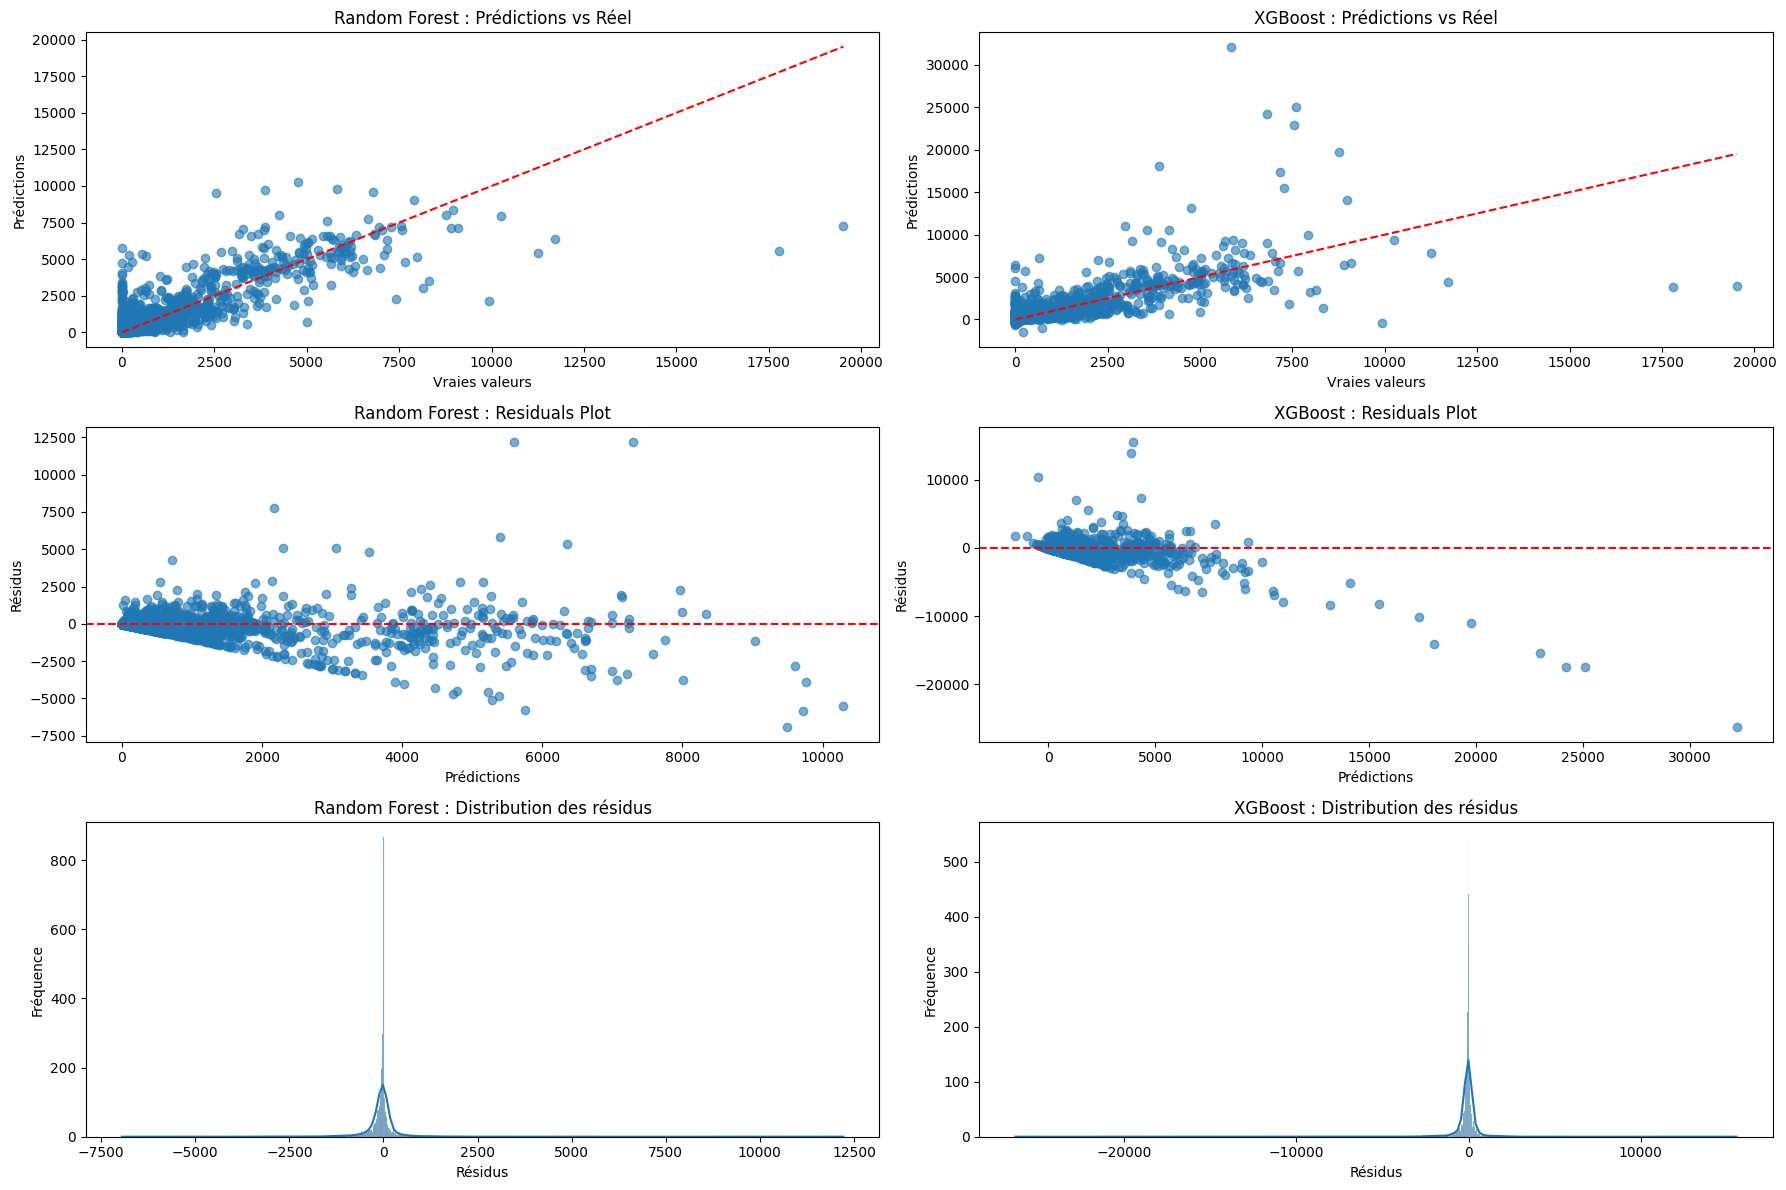

In [21]:
# Dictionnaire des modèles et leurs prédictions
predictions={
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xg,
}

fig, axes=plt.subplots(3, 2, figsize=(18, 12))

for col, (name, y_pred) in enumerate(predictions.items()):
    residuals=y_test - y_pred

    # 1ère ligne : scatter prédictions vs vrai + diagonale
    axes[0, col].scatter(y_test, y_pred, alpha=0.6)
    axes[0, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, col].set_title(f"{name} : Prédictions vs Réel")
    axes[0, col].set_xlabel("Vraies valeurs")
    axes[0, col].set_ylabel("Prédictions")

    # 2ème ligne : residuals plot
    axes[1, col].scatter(y_pred, residuals, alpha=0.6)
    axes[1, col].axhline(0, color='r', linestyle='--')
    axes[1, col].set_title(f"{name} : Residuals Plot")
    axes[1, col].set_xlabel("Prédictions")
    axes[1, col].set_ylabel("Résidus")

    # 3ème ligne : distribution des résidus
    sns.histplot(residuals, kde=True, ax=axes[2, col])
    axes[2, col].set_title(f"{name} : Distribution des résidus")
    axes[2, col].set_xlabel("Résidus")
    axes[2, col].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

In [22]:
"""from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import joblib

# Définir la grille de paramètres
param_grid_xgb={
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Créer le modèle de base
xgb_base=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# GridSearchCV
grid_search_xgb=GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# Lancer la recherche
print("Démarrage de la recherche par grille XGBoost...")
grid_search_xgb.fit(X_train, y_train)

# Meilleur modèle
best_xgb_model=grid_search_xgb.best_estimator_

print("\nMeilleurs paramètres trouvés :")
print(grid_search_xgb.best_params_)
print(f"\nMeilleur score CV : {-grid_search_xgb.best_score_:.4f}")

# Prédictions
y_pred_xgb=best_xgb_model.predict(X_test)
y_pred_xgbT=best_xgb_model.predict(X_train)

# Évaluation
mse_test=mean_squared_error(y_test, y_pred_xgb)
mse_train=mean_squared_error(y_train, y_pred_xgbT)
r2_test=r2_score(y_test, y_pred_xgb)
r2_train=r2_score(y_train, y_pred_xgbT)

print("\n=== RÉSULTATS DU MEILLEUR MODÈLE XGBoost ===")
print(f"MSE Test : {mse_test:.4f}")
print(f"MSE Train : {mse_train:.4f}")
print(f"R² Test : {r2_test:.4f}")
print(f"R² Train : {r2_train:.4f}")

# Importance des features
if hasattr(X_train, 'columns'):
    feature_importance=pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== IMPORTANCE DES FEATURES ===")
    print(feature_importance.head(10))

# Sauvegarde du modèle
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')
print("\nModèle sauvegardé sous 'best_xgb_model.pkl'")

# Résultats complets
results_df=pd.DataFrame(grid_search_xgb.cv_results_)
print(f"\nNombre total de combinaisons testées : {len(results_df)}")
print("\nTop 5 des meilleures combinaisons :")
print(results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']])"""

#{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


'from xgboost import XGBRegressor\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error\nimport numpy as np\nimport pandas as pd\nimport joblib\n\n# Définir la grille de paramètres\nparam_grid_xgb={\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [3, 6, 10],\n    \'learning_rate\': [0.01, 0.1, 0.3],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.8, 1.0],\n    \'gamma\': [0, 1, 5]\n}\n\n# Créer le modèle de base\nxgb_base=XGBRegressor(objective=\'reg:squarederror\', random_state=42, n_jobs=-1)\n\n# GridSearchCV\ngrid_search_xgb=GridSearchCV(\n    estimator=xgb_base,\n    param_grid=param_grid_xgb,\n    cv=5,\n    scoring=\'neg_mean_absolute_error\',\n    n_jobs=-1,\n    verbose=2\n)\n\n# Lancer la recherche\nprint("Démarrage de la recherche par grille XGBoost...")\ngrid_search_xgb.fit(X_train, y_train)\n\n# Meilleur modèle\nbest_xgb_model=grid_search_xgb.best_estimator_\n\nprint("\nMeil

In [23]:
"""from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Définir la grille de paramètres à tester
param_grid={
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Version plus rapide avec moins de paramètres (recommandée pour commencer)
param_grid_light={
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Créer le modèle de base
rf_base=RandomForestRegressor(random_state=42, n_jobs=-1)

# Créer le GridSearchCV
# Utilisez param_grid_light pour une recherche plus rapide
grid_search=GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,  # Changez en param_grid pour une recherche complète
    cv=5,  # Validation croisée à 5 plis
    scoring='neg_mean_absolute_error',  # Métrique d'évaluation MAE
    n_jobs=-1,  # Utiliser tous les processeurs disponibles
    verbose=2  # Afficher le progrès
)

# Lancer la recherche
print("Démarrage de la recherche par grille...")
grid_search.fit(X_train, y_train)

# Récupérer le meilleur modèle
best_rf_model=grid_search.best_estimator_

# Afficher les meilleurs paramètres
print("\nMeilleurs paramètres trouvés:")
print(grid_search.best_params_)
print(f"\nMeilleur score CV: {-grid_search.best_score_:.4f}")

# Faire les prédictions avec le meilleur modèle
y_pred_rf=best_rf_model.predict(X_test)
y_pred_rfT=best_rf_model.predict(X_train)

# Évaluer les performances
mse_test=mean_squared_error(y_test, y_pred_rf)
mse_train=mean_squared_error(y_train, y_pred_rfT)
r2_test=r2_score(y_test, y_pred_rf)
r2_train=r2_score(y_train, y_pred_rfT)

print("\n=== RÉSULTATS DU MEILLEUR MODÈLE ===")
print(f"MSE Test: {mse_test:.4f}")
print(f"MSE Train: {mse_train:.4f}")
print(f"R² Test: {r2_test:.4f}")
print(f"R² Train: {r2_train:.4f}")

# Afficher l'importance des features du meilleur modèle
if hasattr(X_train, 'columns'):
    feature_importance=pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== IMPORTANCE DES FEATURES ===")
    print(feature_importance.head(10))

# Optionnel: Sauvegarder le modèle
import joblib
joblib.dump(best_rf_model, 'best_random_forest_model.pkl')
print("\nModèle sauvegardé sous 'best_random_forest_model.pkl'")

# Optionnel: Analyser tous les résultats
results_df=pd.DataFrame(grid_search.cv_results_)
print(f"\nNombre total de combinaisons testées: {len(results_df)}")
print("\nTop 5 des meilleures combinaisons:")
print(results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']])

#{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}"""
#{'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error\nimport numpy as np\n\n# Définir la grille de paramètres à tester\nparam_grid={\n    \'n_estimators\': [50, 100, 200, 300],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\', None],\n    \'bootstrap\': [True, False]\n}\n\n# Version plus rapide avec moins de paramètres (recommandée pour commencer)\nparam_grid_light={\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 20, 30],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'max_features\': [\'sqrt\', \'log2\']\n}\n\n# Créer le modèle de base\nrf_base=RandomForestRegressor(random_state=42, n_jobs=-1)\n\n# Créer le GridSearchCV\n# Utilisez param_grid_light pour une recherche plus rapide\ngrid_search=GridSear

Entraînement des modèles d'ensemble d'arbre avec les hyperparamètres optimisés

In [24]:
##############################################RandomForest model##########################################################

rf_model=RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
rf_model.fit(X_train, y_train)
# Résultats du GridSearch{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

y_pred_rf= pd.Series(rf_model.predict(X_test), index=y_test.index)
y_pred_rfT=pd.Series(rf_model.predict(X_train), index=y_train.index)


rmse_rf=np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf=mean_absolute_error(y_test, y_pred_rf)
r2_rf=r2_score(y_test, y_pred_rf) 



rmse_rfT=np.sqrt(mean_squared_error(y_train, y_pred_rfT))
mae_rfT=mean_absolute_error(y_train, y_pred_rfT)
r2_rfT=r2_score(y_train, y_pred_rfT) 


##############################################XGBoost model ##########################################################

xg_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
)
xg_model.fit(X_train, y_train)
# Résultat de la GridSearch{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# Making predictions
y_pred_xg=pd.Series(xg_model.predict(X_test), index=y_test.index)
y_pred_xgT=pd.Series(xg_model.predict(X_train), index=y_train.index)


rmse_xg=np.sqrt(mean_squared_error(y_test, y_pred_xg))
mae_xg=mean_absolute_error(y_test, y_pred_xg)
r2_xg=r2_score(y_test, y_pred_xg)



rmse_xgT=np.sqrt(mean_squared_error(y_train, y_pred_xgT))
mae_xgT=mean_absolute_error(y_train, y_pred_xgT)
r2_xgT=r2_score(y_train, y_pred_xgT) 


##############################################Prédictions manuelles ##########################################################


rmse_fm=np.sqrt(mean_squared_error(y_test, forecast_test))
mae_fm=mean_absolute_error(y_test, forecast_test)
r2_fm=r2_score(y_test, forecast_test) 


rmse_fmT=np.sqrt(mean_squared_error(y_train, forecast_train))
mae_fmT=mean_absolute_error(y_train, forecast_train)
r2_fmT=r2_score(y_train, forecast_train)


# Collecte des métriques de performance pour l'affichage (test)

performance_metrics={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rf, rmse_xg, rmse_fm],
    'MAE': [mae_rf, mae_xg, mae_fm],
    'R2': [r2_rf, r2_xg, r2_fm],
}

# Collecte des métriques de performance pour l'affichage (train)

performance_metricsT={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rfT, rmse_xgT, rmse_fmT],
    'MAE': [mae_rfT, mae_xgT, mae_fmT],
    'R2': [r2_rfT, r2_xgT, r2_fmT],
}

performance_df=pd.DataFrame(performance_metrics)
performance_dfT=pd.DataFrame(performance_metricsT)

print("\n=== Métriques sur les données de test ===")
print(performance_df)
print("\n=== Métriques sur les données de train ===")
print(performance_dfT)


=== Métriques sur les données de test ===
             Model        RMSE         MAE        R2
0    Random Forest  565.334529  229.391176  0.763311
1          XGBoost  602.228058  266.071415  0.731411
2  Forecast Manuel  739.125330  234.341220  0.595421

=== Métriques sur les données de train ===
             Model         RMSE         MAE        R2
0    Random Forest   659.726829  154.653101  0.745196
1          XGBoost   762.258520  239.205060  0.659841
2  Forecast Manuel  1106.905587  236.206209  0.282704


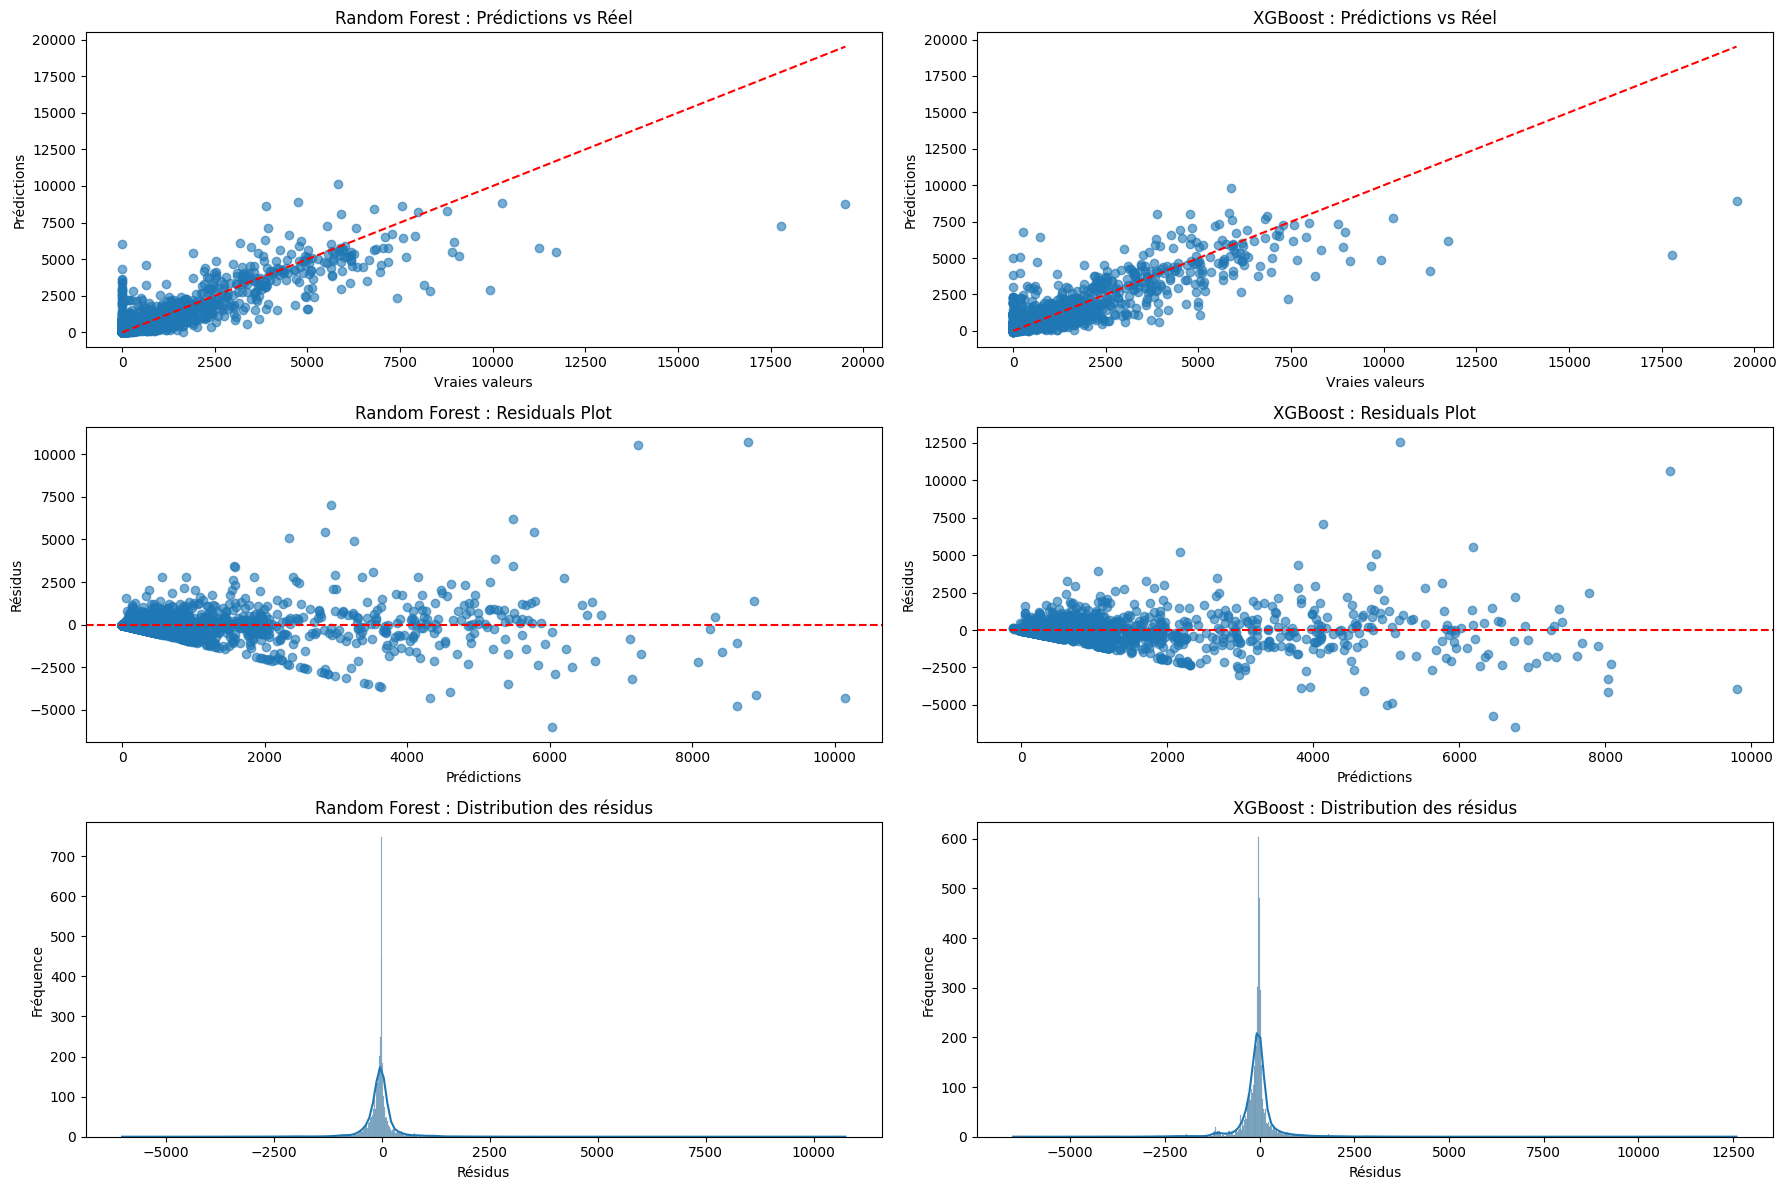

In [25]:
# Dictionnaire des modèles et leurs prédictions
predictions = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xg,
}

fig, axes = plt.subplots(3, 2, figsize=(18, 12))

for col, (name, y_pred) in enumerate(predictions.items()):
    residuals = y_test - y_pred

    # 1ère ligne : scatter prédictions vs vrai + diagonale
    axes[0, col].scatter(y_test, y_pred, alpha=0.6)
    axes[0, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, col].set_title(f"{name} : Prédictions vs Réel")
    axes[0, col].set_xlabel("Vraies valeurs")
    axes[0, col].set_ylabel("Prédictions")

    # 2ème ligne : residuals plot
    axes[1, col].scatter(y_pred, residuals, alpha=0.6)
    axes[1, col].axhline(0, color='r', linestyle='--')
    axes[1, col].set_title(f"{name} : Residuals Plot")
    axes[1, col].set_xlabel("Prédictions")
    axes[1, col].set_ylabel("Résidus")

    # 3ème ligne : distribution des résidus
    sns.histplot(residuals, kde=True, ax=axes[2, col])
    axes[2, col].set_title(f"{name} : Distribution des résidus")
    axes[2, col].set_xlabel("Résidus")
    axes[2, col].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

Comparaison des données transformées vs non transformées

In [26]:
# Separating features and target variable
X = df.drop(columns=['VENTES','CODE_ARTICLE','future'])
y = np.sqrt(df['VENTES'])
#y = np.log(df['VENTES']+1)

# Splitting the data into training and testing sets (temporal split before/after 2023)
train_mask = df['year'] < 2024
test_mask = df['year'] >= 2024

X_train = X[train_mask].drop(columns=['VENTES_PREDITES'])
X_test = X[test_mask].drop(columns=['VENTES_PREDITES'])
y_train = y[train_mask]
y_test = y[test_mask]
forecast_train = X[train_mask]['VENTES_PREDITES']
forecast_test = X[test_mask]['VENTES_PREDITES']

In [27]:
##############################################RandomForest model##########################################################

rf_model=RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
rf_model.fit(X_train, y_train)
# Résultats du GridSearch{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

y_pred_rf= pd.Series(rf_model.predict(X_test), index=y_test.index)
y_pred_rfT=pd.Series(rf_model.predict(X_train), index=y_train.index)

y_test_og = y_test ** 2
y_train_og = y_train ** 2
y_pred_rf_og = y_pred_rf ** 2
y_pred_rfT_og = y_pred_rfT ** 2


rmse_rf=np.sqrt(mean_squared_error(y_test_og, y_pred_rf_og))
mae_rf=mean_absolute_error(y_test_og, y_pred_rf_og)
r2_rf=r2_score(y_test_og, y_pred_rf_og) 



rmse_rfT=np.sqrt(mean_squared_error(y_train_og, y_pred_rfT_og))
mae_rfT=mean_absolute_error(y_train_og, y_pred_rfT_og)
r2_rfT=r2_score(y_train_og, y_pred_rfT_og)


##############################################XGBoost model ##########################################################

xg_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
)
xg_model.fit(X_train, y_train)
# Résultat de la GridSearch{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# Making predictions
y_pred_xg=pd.Series(xg_model.predict(X_test), index=y_test.index)
y_pred_xgT=pd.Series(xg_model.predict(X_train), index=y_train.index)

y_test_og = y_test ** 2
y_train_og = y_train ** 2
y_pred_xg_og = y_pred_xg ** 2
y_pred_xgT_og = y_pred_xgT ** 2


rmse_xg=np.sqrt(mean_squared_error(y_test_og, y_pred_xg_og))
mae_xg=mean_absolute_error(y_test_og, y_pred_xg_og)
r2_xg=r2_score(y_test_og, y_pred_xg_og)



rmse_xgT=np.sqrt(mean_squared_error(y_train_og, y_pred_xgT_og))
mae_xgT=mean_absolute_error(y_train_og, y_pred_xgT_og)
r2_xgT=r2_score(y_train, y_pred_xgT) 


##############################################Prédictions manuelles ##########################################################


rmse_fm=np.sqrt(mean_squared_error(y_test, forecast_test))
mae_fm=mean_absolute_error(y_test, forecast_test)
r2_fm=r2_score(y_test, forecast_test) 


rmse_fmT=np.sqrt(mean_squared_error(y_train, forecast_train))
mae_fmT=mean_absolute_error(y_train, forecast_train)
r2_fmT=r2_score(y_train, forecast_train)


# Collecte des métriques de performance pour l'affichage (test)

performance_metrics={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rf, rmse_xg, rmse_fm],
    'MAE': [mae_rf, mae_xg, mae_fm],
    'R2': [r2_rf, r2_xg, r2_fm],
}

# Collecte des métriques de performance pour l'affichage (train)

performance_metricsT={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rfT, rmse_xgT, rmse_fmT],
    'MAE': [mae_rfT, mae_xgT, mae_fmT],
    'R2': [r2_rfT, r2_xgT, r2_fmT],
}

performance_df=pd.DataFrame(performance_metrics)
performance_dfT=pd.DataFrame(performance_metricsT)

print("\n=== Métriques sur les données de test ===")
print(performance_df)
print("\n=== Métriques sur les données de train ===")
print(performance_dfT)


=== Métriques sur les données de test ===
             Model         RMSE         MAE           R2
0    Random Forest   592.132050  210.333089     0.740341
1          XGBoost   623.719401  230.681697     0.711899
2  Forecast Manuel  1536.716840  580.779146 -8162.945060

=== Métriques sur les données de train ===
             Model         RMSE         MAE           R2
0    Random Forest   725.284079  141.407864     0.692040
1          XGBoost   835.414051  206.621723     0.746614
2  Forecast Manuel  1473.875226  448.565601 -8731.096287


Visualisation des perfomances du modèles random forest

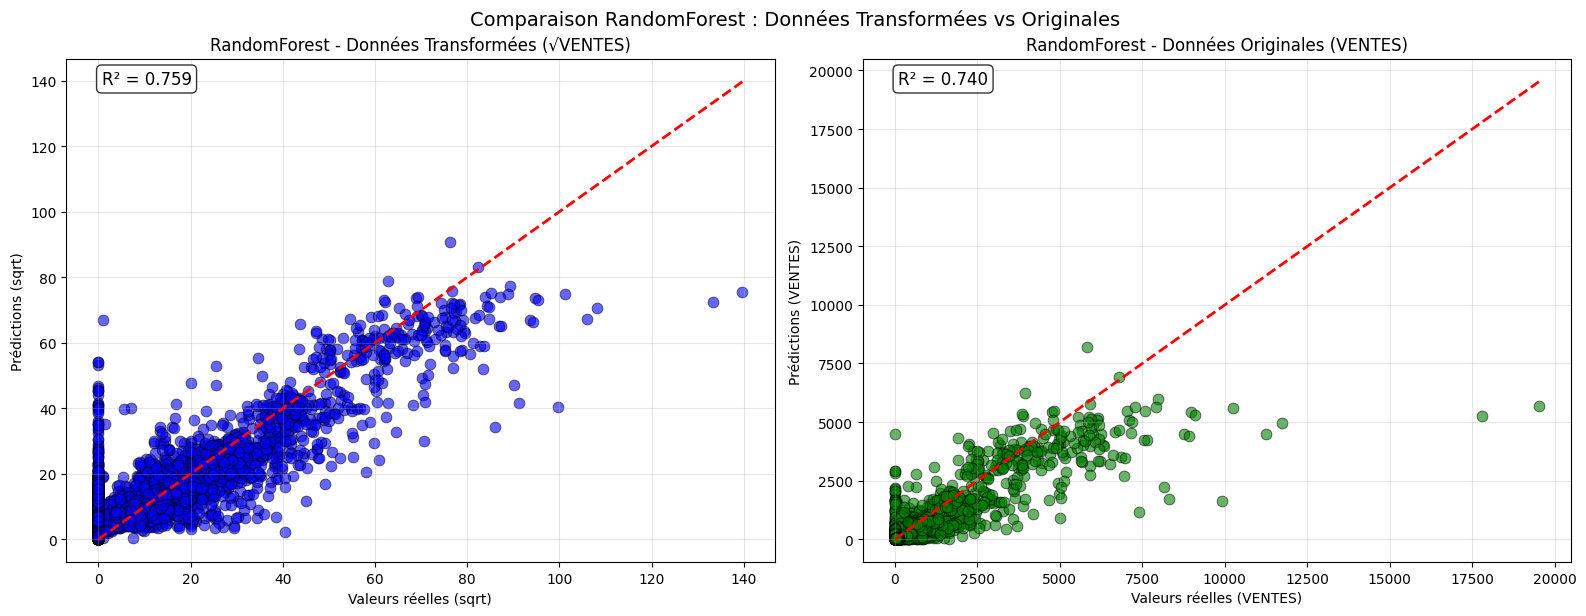

In [28]:
# Calcul des données originales
y_test_pred_original_rf = y_pred_rf ** 2
y_test_original = y_test ** 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique : Données transformées (racine)
sns.scatterplot(x=y_test, y=y_pred_rf, color='blue', s=60, alpha=0.6, 
                edgecolor='k', ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             color='red', lw=2, linestyle='--')
axes[0].set_xlabel('Valeurs réelles (sqrt)')
axes[0].set_ylabel('Prédictions (sqrt)')
axes[0].set_title('RandomForest - Données Transformées (√VENTES)')
axes[0].grid(True, alpha=0.3)

# Calcul du R² pour le titre
r2_transformed = r2_score(y_test, y_pred_rf)
axes[0].text(0.05, 0.95, f'R² = {r2_transformed:.3f}', 
             transform=axes[0].transAxes, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Deuxième graphique : Données originales
sns.scatterplot(x=y_test_original, y=y_test_pred_original_rf, color='green', s=60, 
                alpha=0.6, edgecolor='k', ax=axes[1])
axes[1].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             color='red', lw=2, linestyle='--')
axes[1].set_xlabel('Valeurs réelles (VENTES)')
axes[1].set_ylabel('Prédictions (VENTES)')
axes[1].set_title('RandomForest - Données Originales (VENTES)')
axes[1].grid(True, alpha=0.3)

# Calcul du R² pour les données originales
r2_original = r2_score(y_test_original, y_test_pred_original_rf)
axes[1].text(0.05, 0.95, f'R² = {r2_original:.3f}', 
             transform=axes[1].transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
fig.suptitle('Comparaison RandomForest : Données Transformées vs Originales', 
             fontsize=14, y=1.02)

plt.show()

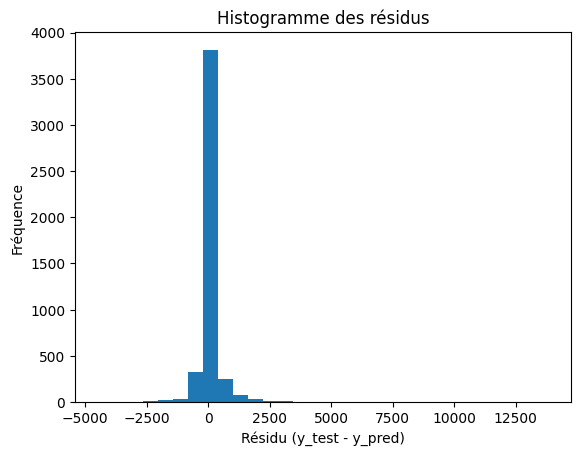

In [29]:
residus = y_test_original - y_test_pred_original_rf

# Tracer l'histogramme
plt.hist(residus, bins=30)
plt.title("Histogramme des résidus")
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")
plt.show()

Visualisation des performances du modèle XGBoost

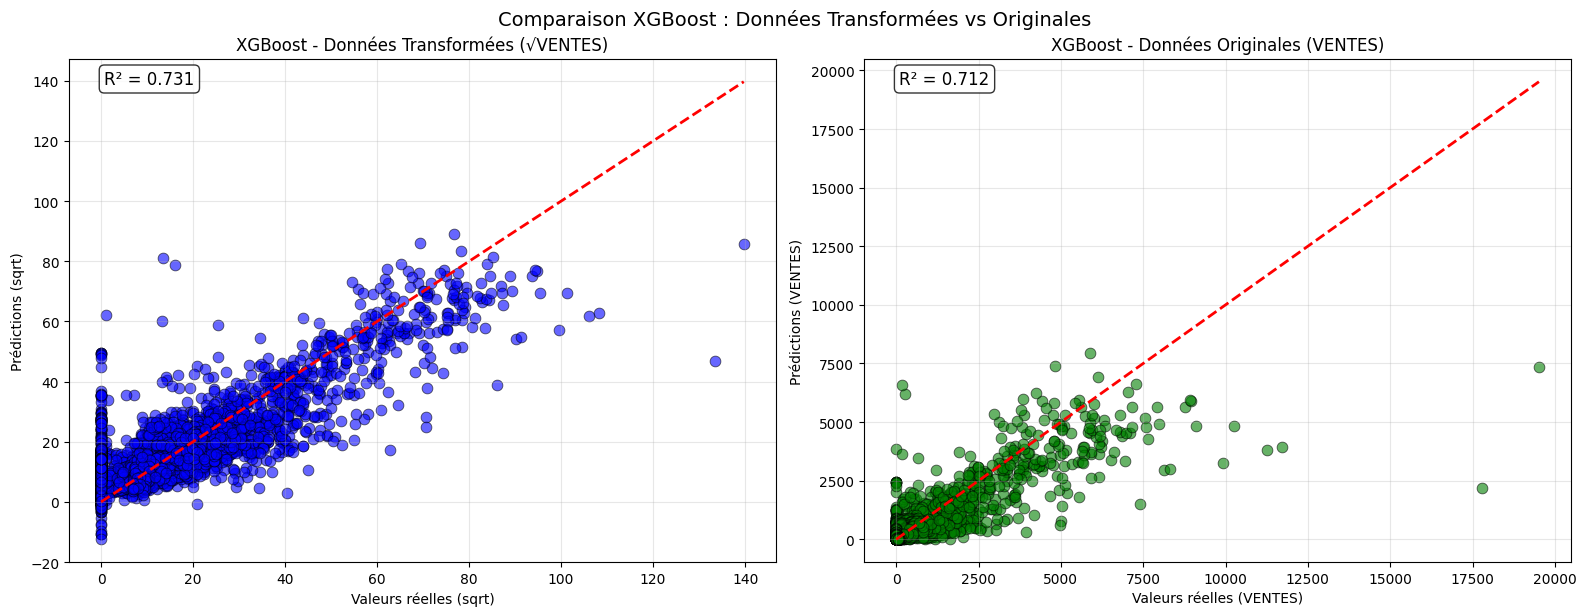

In [30]:
# Calcul des données originales
y_test_pred_original_xg = y_pred_xg ** 2
y_test_original = y_test ** 2
#y_test_pred_original_xg = np.expm1(y_pred_xg)
#y_test_original = np.expm1(y_test)

# Création de la figure avec 2 subplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique : Données transformées (racine)
sns.scatterplot(x=y_test, y=y_pred_xg, color='blue', s=60, alpha=0.6, 
                edgecolor='k', ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             color='red', lw=2, linestyle='--')
axes[0].set_xlabel('Valeurs réelles (sqrt)')
axes[0].set_ylabel('Prédictions (sqrt)')
axes[0].set_title('XGBoost - Données Transformées (√VENTES)')
axes[0].grid(True, alpha=0.3)

# Calcul du R² pour le titre
from sklearn.metrics import r2_score
r2_transformed = r2_score(y_test, y_pred_xg)
axes[0].text(0.05, 0.95, f'R² = {r2_transformed:.3f}', 
             transform=axes[0].transAxes, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Deuxième graphique : Données originales
sns.scatterplot(x=y_test_original, y=y_test_pred_original_xg, color='green', s=60, 
                alpha=0.6, edgecolor='k', ax=axes[1])
axes[1].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             color='red', lw=2, linestyle='--')
axes[1].set_xlabel('Valeurs réelles (VENTES)')
axes[1].set_ylabel('Prédictions (VENTES)')
axes[1].set_title('XGBoost - Données Originales (VENTES)')
axes[1].grid(True, alpha=0.3)

# Calcul du R² pour les données originales
r2_original = r2_score(y_test_original, y_test_pred_original_xg)
axes[1].text(0.05, 0.95, f'R² = {r2_original:.3f}', 
             transform=axes[1].transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Ajustement de l'espacement entre les graphiques
plt.tight_layout()

# Titre général
fig.suptitle('Comparaison XGBoost : Données Transformées vs Originales', 
             fontsize=14, y=1.02)

plt.show()

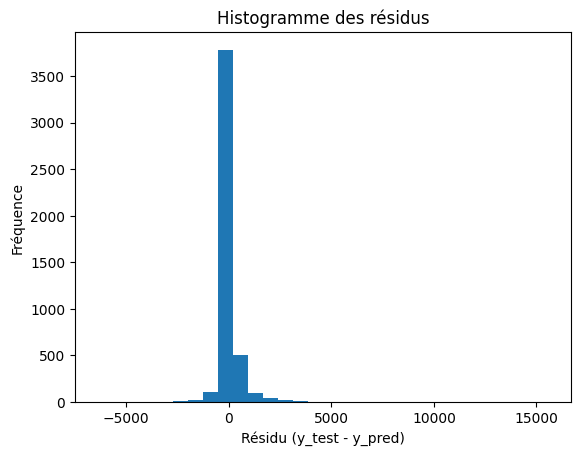

In [31]:
residus = y_test_original - y_test_pred_original_xg

# Tracer l'histogramme
plt.hist(residus, bins=30)
plt.title("Histogramme des résidus")
plt.xlabel("Résidu (y_test - y_pred)")
plt.ylabel("Fréquence")
plt.show()

                       Feature  Importance
0                STOCK_INITIAL    0.348821
6          CODE_ART_encoded_cv    0.203641
1                  REGULATIONS    0.085790
2                     RETARDES    0.073431
23   CLIENT_CATEGORY_VeryLarge    0.057053
7                         year    0.048888
5             DELAI_DE_TRANSIT    0.043953
26  SYMPTOM_CATEGORY_VeryLarge    0.027319
11                    week_cos    0.011042
14                  MARCHE_UPM    0.010822
10                    week_sin    0.010676
22       CLIENT_CATEGORY_Large    0.009157
4                         MOIS    0.008883
20  COUNTRY_CATEGORY_VeryLarge    0.008356
21      CLIENT_CATEGORY_Medium    0.007197
12                  MARCHE_UPE    0.006878
9                    month_cos    0.006814
8                    month_sin    0.006168
19      COUNTRY_CATEGORY_Large    0.005342
24     SYMPTOM_CATEGORY_Medium    0.005138
25      SYMPTOM_CATEGORY_Large    0.005122
18     COUNTRY_CATEGORY_Medium    0.003855
16         

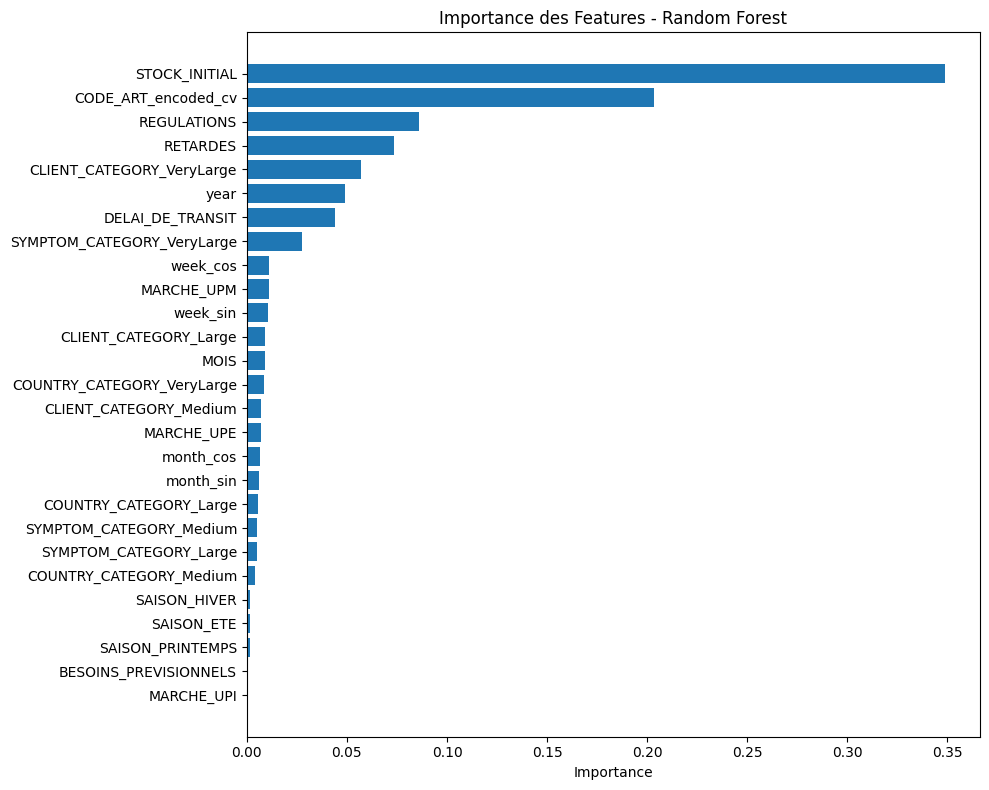

In [32]:
# Récupérer les importances des features
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Créer un DataFrame pour visualiser
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(importance_df)

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])  # Top 15
plt.xlabel('Importance')
plt.title('Importance des Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Visualisations des performances du modèle sur de vraies données futures. On se basera sur les article le plus vendu en:
IRAK = N1-400-IQ 79 000 cartons vendus jusqu'à aujourd'hui en 2025
Anglo-Arabe = N3V-800M-AA 95 000 cartons vendus jusqu'à aujourd'hui en 2025
Arabie-Saoudite = N3VE-400-SA 75 000 cartons vendus jusqu'à aujourd'hui
France= N3V-800S-FR 39 000 cartons vendus jusqu'à aujourd'hui

**Pour cette partie il faut faire tourner le code de nouveau en inhibant cette ligne "df = df[df['ANNEE']<2025]" dans le premier bloc de code**

In [33]:
#concatener df
df = pd.concat([df, df_future])

In [34]:
print(df['year'].unique())
print(df['future'].unique())

[2022 2023 2024 2020 2021 2008 2009 2010 2011 2012 2013 2019 2017 2018
 2014 2015 2016 2025 2026 2027]
[0 1]


In [35]:
# Splitting the data into training and testing sets (temporal split before/after 2023)
train_mask = df['future'] == 0
test_mask = df['future'] == 1

# Separating features and target variable
X= df.drop(columns=['VENTES','CODE_ARTICLE','future'])
y = np.sqrt(df['VENTES'])

X_train = X[train_mask].drop(columns=['VENTES_PREDITES'])
X_test = X[test_mask].drop(columns=['VENTES_PREDITES'])
y_train = y[train_mask]
y_test = y[test_mask]
forecast_train = X[train_mask]['VENTES_PREDITES']
forecast_test = X[test_mask]['VENTES_PREDITES']

In [36]:
##############################################RandomForest model##########################################################

rf_model=RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)
rf_model.fit(X_train, y_train)
# Résultats du GridSearch{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

y_pred_rf= pd.Series(rf_model.predict(X_test), index=y_test.index)
y_pred_rfT=pd.Series(rf_model.predict(X_train), index=y_train.index)

y_test_og = y_test ** 2
y_train_og = y_train ** 2
y_pred_rf_og = y_pred_rf ** 2
y_pred_rfT_og = y_pred_rfT ** 2


rmse_rf=np.sqrt(mean_squared_error(y_test_og, y_pred_rf_og))
mae_rf=mean_absolute_error(y_test_og, y_pred_rf_og)
r2_rf=r2_score(y_test_og, y_pred_rf_og) 



rmse_rfT=np.sqrt(mean_squared_error(y_train_og, y_pred_rfT_og))
mae_rfT=mean_absolute_error(y_train_og, y_pred_rfT_og)
r2_rfT=r2_score(y_train_og, y_pred_rfT_og)


##############################################XGBoost model ##########################################################

xg_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
)
xg_model.fit(X_train, y_train)
# Résultat de la GridSearch{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# Making predictions
y_pred_xg=pd.Series(xg_model.predict(X_test), index=y_test.index)
y_pred_xgT=pd.Series(xg_model.predict(X_train), index=y_train.index)

y_test_og = y_test ** 2
y_train_og = y_train ** 2
y_pred_xg_og = y_pred_xg ** 2
y_pred_xgT_og = y_pred_xgT ** 2


rmse_xg=np.sqrt(mean_squared_error(y_test_og, y_pred_xg_og))
mae_xg=mean_absolute_error(y_test_og, y_pred_xg_og)
r2_xg=r2_score(y_test_og, y_pred_xg_og)



rmse_xgT=np.sqrt(mean_squared_error(y_train_og, y_pred_xgT_og))
mae_xgT=mean_absolute_error(y_train_og, y_pred_xgT_og)
r2_xgT=r2_score(y_train, y_pred_xgT) 


##############################################Prédictions manuelles ##########################################################


rmse_fm=np.sqrt(mean_squared_error(y_test, forecast_test))
mae_fm=mean_absolute_error(y_test, forecast_test)
r2_fm=r2_score(y_test, forecast_test) 


rmse_fmT=np.sqrt(mean_squared_error(y_train, forecast_train))
mae_fmT=mean_absolute_error(y_train, forecast_train)
r2_fmT=r2_score(y_train, forecast_train)


# Collecte des métriques de performance pour l'affichage (test)

performance_metrics={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rf, rmse_xg, rmse_fm],
    'MAE': [mae_rf, mae_xg, mae_fm],
    'R2': [r2_rf, r2_xg, r2_fm],
}

# Collecte des métriques de performance pour l'affichage (train)

performance_metricsT={
    'Model': ['Random Forest', 'XGBoost', 'Forecast Manuel'],
    'RMSE': [rmse_rfT, rmse_xgT, rmse_fmT],
    'MAE': [mae_rfT, mae_xgT, mae_fmT],
    'R2': [r2_rfT, r2_xgT, r2_fmT],
}

performance_df=pd.DataFrame(performance_metrics)
performance_dfT=pd.DataFrame(performance_metricsT)

print("\n=== Métriques sur les données de test ===")
print(performance_df)
print("\n=== Métriques sur les données de train ===")
print(performance_dfT)


=== Métriques sur les données de test ===
             Model        RMSE         MAE        R2
0    Random Forest  642.836867  268.714959  0.619081
1          XGBoost  708.740802  298.452604  0.536974
2  Forecast Manuel   19.649430   11.158588 -0.475997

=== Métriques sur les données de train ===
             Model         RMSE         MAE           R2
0    Random Forest   700.567653  142.235938     0.701394
1          XGBoost   820.627464  211.640432     0.738710
2  Forecast Manuel  1433.049616  433.908678 -8104.199905


In [37]:
df['MONTH']=decode_cyclic(df['month_sin'], df['month_cos'],12)

df1 = df.copy()
df1['year_month'] = df['MONTH'].astype(str) + '-' + df['year'].astype(str).str[-2:]
df1['year_month'] = pd.to_datetime(df1['year_month'], format='%m-%y')


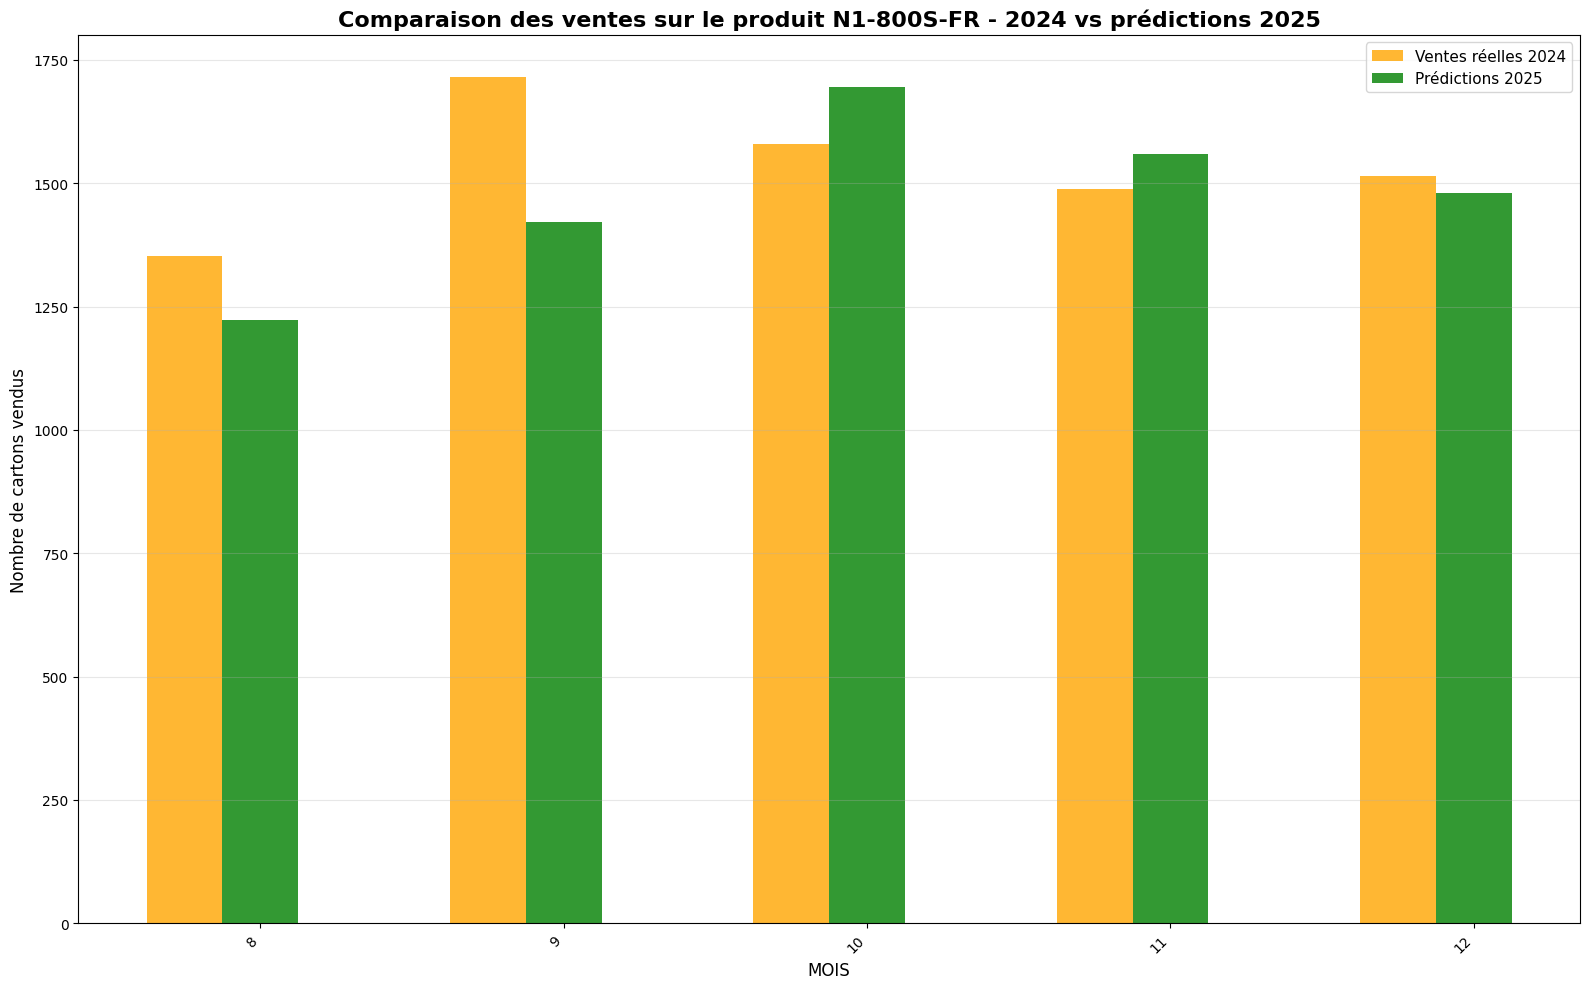

In [38]:
# Créer un DataFrame avec toutes les données de test
df_test = df1[df1.index.isin(X_test.index)].copy()
# Créer un DataFrame avec toutes les données de train
df_train = df1[df1.index.isin(X_train.index)].copy()

mask_t = df_test['CODE_ARTICLE']=="N1-800S-FR"
mask_T = (df_train['CODE_ARTICLE']=="N1-800S-FR") & (df_train['year_month'] >= pd.to_datetime('01/08/2024', dayfirst=True)) & (df_train['year'] == 2024)

df_test_filtre = df_test[mask_t].copy()
df_train_filtre = df_train[mask_T].copy()

df_test_filtre['ventes_pred_modele_2025'] = (y_pred_rf[mask_t].copy())**2

# Grouper par article et sommer les ventes
ventes_par_article_2025 = df_test_filtre.groupby('MONTH').agg({
    'ventes_pred_modele_2025': 'sum'
}).reset_index()

ventes_par_article_2024 = df_train_filtre.groupby('MONTH').agg({
    'VENTES': 'sum', 
}).reset_index()

plt.figure(figsize=(16, 10))

x = np.arange(len(ventes_par_article_2024))
width = 0.25

plt.bar(x - width, ventes_par_article_2024['VENTES'], width, 
        label='Ventes réelles 2024', color='orange', alpha=0.8)
plt.bar(x, ventes_par_article_2025['ventes_pred_modele_2025'], width, 
        label='Prédictions 2025', color='green', alpha=0.8)

plt.title('Comparaison des ventes sur le produit N1-800S-FR - 2024 vs prédictions 2025', fontsize=16, fontweight='bold')
plt.xlabel('MOIS', fontsize=12)
plt.ylabel('Nombre de cartons vendus', fontsize=12)
plt.legend(fontsize=11)
plt.xticks(x, ventes_par_article_2024['MONTH'], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

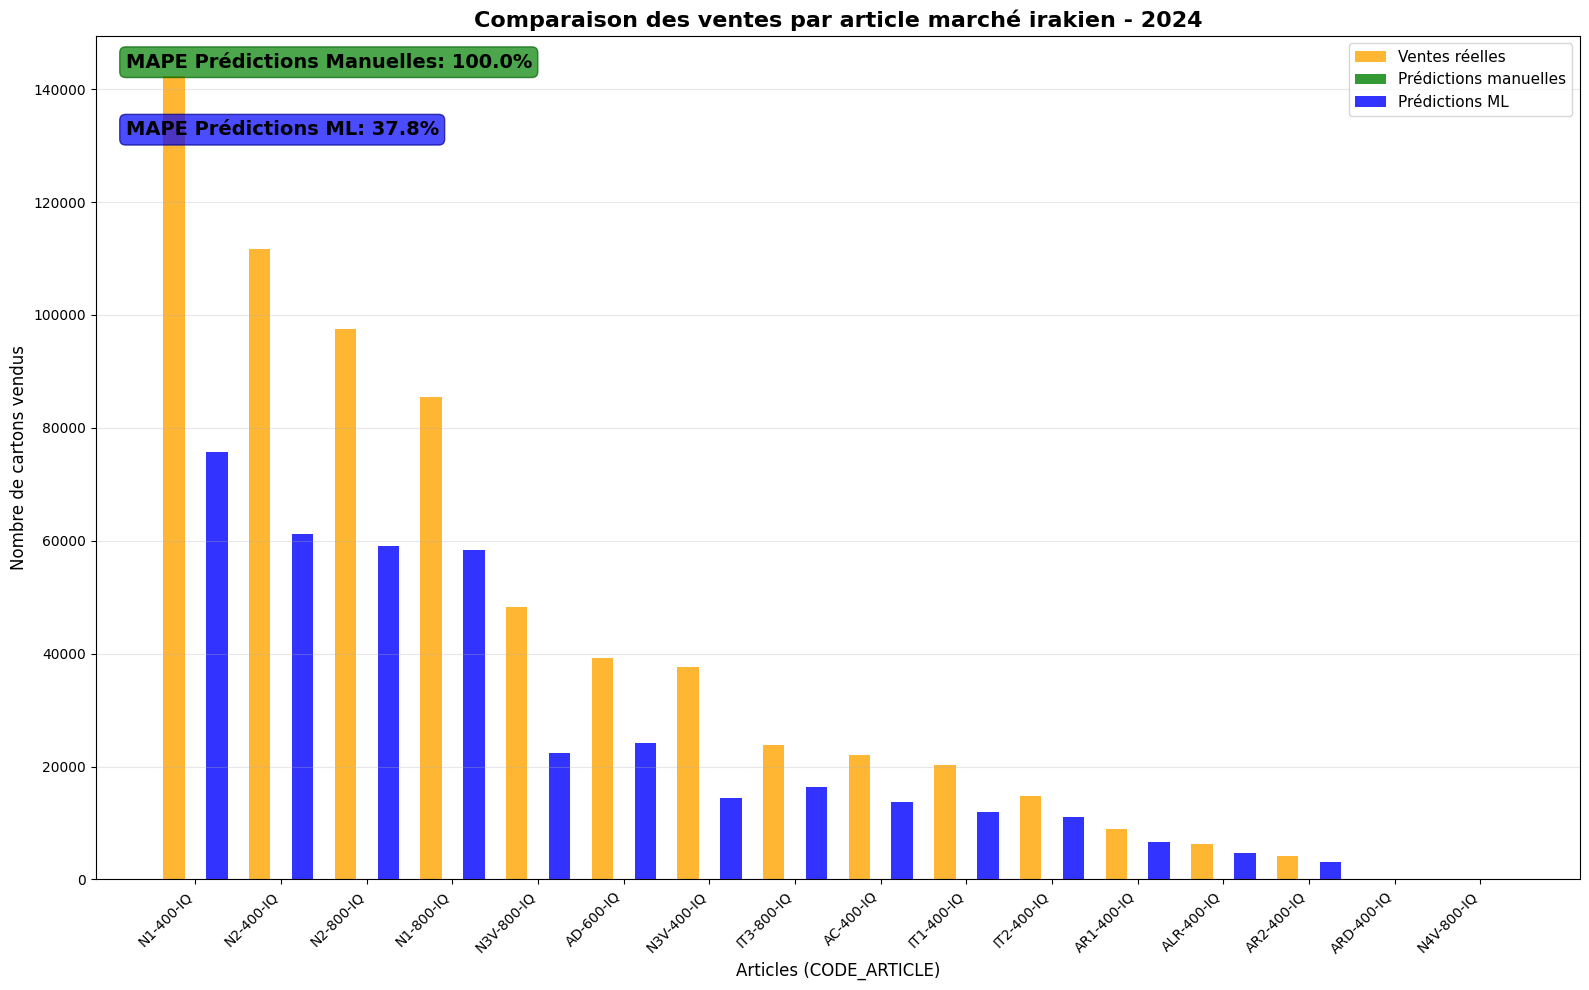

In [39]:
# Créer un DataFrame avec toutes les données de test
df_test = df[df.index.isin(X_test.index)].copy()

# Filtre pour les articles irakiens (finissent par "-IQ")
mask_fr = df_test['CODE_ARTICLE'].str.endswith('-IQ')

# Appliquer le filtre irakien
df_test_fr = df_test[mask_fr].copy()

# Ajouter les prédictions au DataFrame filtré
df_test_fr['ventes_reelles'] = (y_test[mask_fr].copy())**2
df_test_fr['ventes_pred_manuelles'] = forecast_test[mask_fr].copy()
df_test_fr['ventes_pred_modele'] = (y_pred_rf[mask_fr].copy())**2

# Grouper par article et sommer les ventes
ventes_par_article = df_test_fr.groupby('CODE_ARTICLE').agg({
    'ventes_reelles': 'sum',
    'ventes_pred_manuelles': 'sum', 
    'ventes_pred_modele': 'sum'
}).reset_index()

# Trier par ventes réelles décroissantes
ventes_par_article = ventes_par_article.sort_values('ventes_reelles', ascending=False)

# Fonction pour calculer le MAPE
def calculate_mape(y_true, y_pred):
    """
    Calcule le MAPE (Mean Absolute Percentage Error)
    Évite la division par zéro en excluant les valeurs réelles nulles
    """
    # Filtrer les valeurs où y_true n'est pas zéro pour éviter la division par zéro
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculer les MAPE
mape_ml = calculate_mape(ventes_par_article['ventes_reelles'].values, 
                        ventes_par_article['ventes_pred_modele'].values)

mape_manuel = calculate_mape(ventes_par_article['ventes_reelles'].values, 
                            ventes_par_article['ventes_pred_manuelles'].values)

# Créer le graphique
plt.figure(figsize=(16, 10))

x = np.arange(len(ventes_par_article))
width = 0.25

plt.bar(x - width, ventes_par_article['ventes_reelles'], width, 
        label='Ventes réelles', color='orange', alpha=0.8)
plt.bar(x, ventes_par_article['ventes_pred_manuelles'], width, 
        label='Prédictions manuelles', color='green', alpha=0.8)
plt.bar(x + width, ventes_par_article['ventes_pred_modele'], width, 
        label='Prédictions ML', color='blue', alpha=0.8)

plt.title('Comparaison des ventes par article marché irakien - 2024', fontsize=16, fontweight='bold')
plt.xlabel('Articles (CODE_ARTICLE)', fontsize=12)
plt.ylabel('Nombre de cartons vendus', fontsize=12)
plt.legend(fontsize=11)

# Rotation des labels d'articles
plt.xticks(x, ventes_par_article['CODE_ARTICLE'], rotation=45, ha='right')

# Grille pour faciliter la lecture
plt.grid(True, alpha=0.3, axis='y')

# Afficher les MAPE sur la figure
max_y = max(ventes_par_article[['ventes_reelles', 'ventes_pred_manuelles', 'ventes_pred_modele']].max())
plt.text(0.02, 0.98, f'MAPE Prédictions Manuelles: {mape_manuel:.1f}%', 
         transform=plt.gca().transAxes, fontsize=14, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.7, edgecolor='darkgreen'))

plt.text(0.02, 0.90, f'MAPE Prédictions ML: {mape_ml:.1f}%', 
         transform=plt.gca().transAxes, fontsize=14, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.7, edgecolor='darkblue'))

plt.tight_layout()
plt.show()

# Code annexe
Partie à part qui n'a finalement pas été exploitée. Les codes pour la régression échelonnée ainsi que des essaies avec HuberRegressor. 

Taille du jeu d'entraînement: (34769, 29)
Taille du jeu de test: (17464, 29)
Entraînement du Huber Regressor...


c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Prédictions en cours...

=== RÉSULTATS HUBER REGRESSOR ===

Métriques sur données transformées (sqrt):
R² Train: 0.1022
R² Test: -5.9836
RMSE Train: 14.7870
RMSE Test: 43.8764
MAE Train: 7.7919
MAE Test: 13.6386

Métriques sur données originales (VENTES):
R² Train: -6.1214
R² Test: -685.1812
RMSE Train: 3428.06
RMSE Test: 31801.77
MAE Train: 426.06
MAE Test: 2340.35


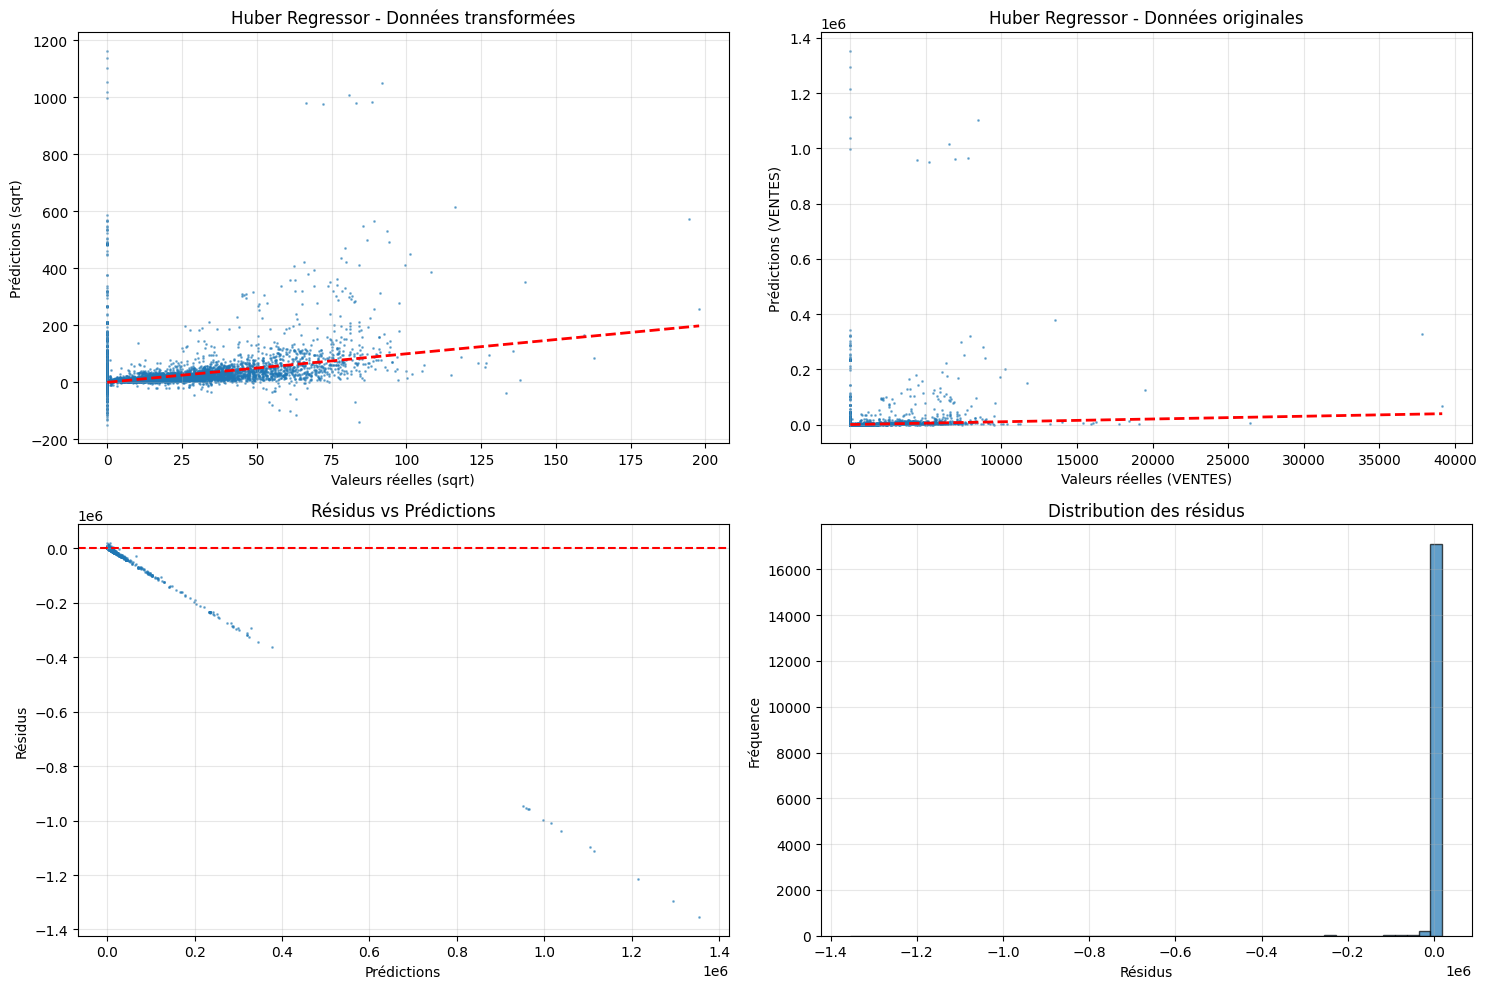


Analyse des outliers (> 7000 cartons):
Nombre d'outliers dans le test: 91
Valeur réelle moyenne des outliers: 10269
Valeur prédite moyenne des outliers: 66803
MAE sur les outliers: 62966.51

Nombre de features utilisées: 29
Entraînement terminé !


In [40]:
from sklearn.linear_model import HuberRegressor

# Separating features and target variable
X = df.drop(columns=['VENTES','CODE_ARTICLE'])
y = np.sqrt(df['VENTES'])

# Splitting the data into training and testing sets (temporal split before/after 2023)
train_mask = df['year'] < 2023
test_mask = df['year'] >= 2023

X_train = X[train_mask].drop(columns=['VENTES_PREDITES'])
X_test = X[test_mask].drop(columns=['VENTES_PREDITES'])
y_train = y[train_mask]
y_test = y[test_mask]
forecast_train = X[train_mask]['VENTES_PREDITES']
forecast_test = X[test_mask]['VENTES_PREDITES']

print(f"Taille du jeu d'entraînement: {X_train.shape}")
print(f"Taille du jeu de test: {X_test.shape}")

# Initialize and train Huber Regressor with default parameters
huber_reg = HuberRegressor(
    epsilon=1.35,      # paramètre par défaut
    max_iter=100,      # nombre d'itérations max
    alpha=0.0001,      # régularisation L2
    warm_start=False,
    fit_intercept=True,
    tol=1e-05
)

print("Entraînement du Huber Regressor...")
huber_reg.fit(X_train, y_train)

# Predictions
print("Prédictions en cours...")
y_train_pred = huber_reg.predict(X_train)
y_test_pred = huber_reg.predict(X_test)

# Retransformation pour obtenir les valeurs originales (on avait fait sqrt)
y_train_pred_original = y_train_pred ** 2
y_test_pred_original = y_test_pred ** 2
y_train_original = y_train ** 2
y_test_original = y_test ** 2

# Calcul des métriques
print("\n=== RÉSULTATS HUBER REGRESSOR ===")
print("\nMétriques sur données transformées (sqrt):")
print(f"R² Train: {r2_score(y_train, y_train_pred):.4f}")
print(f"R² Test: {r2_score(y_test, y_test_pred):.4f}")
print(f"RMSE Train: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"MAE Train: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"MAE Test: {mean_absolute_error(y_test, y_test_pred):.4f}")

print("\nMétriques sur données originales (VENTES):")
print(f"R² Train: {r2_score(y_train_original, y_train_pred_original):.4f}")
print(f"R² Test: {r2_score(y_test_original, y_test_pred_original):.4f}")
print(f"RMSE Train: {np.sqrt(mean_squared_error(y_train_original, y_train_pred_original)):.2f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test_original, y_test_pred_original)):.2f}")
print(f"MAE Train: {mean_absolute_error(y_train_original, y_train_pred_original):.2f}")
print(f"MAE Test: {mean_absolute_error(y_test_original, y_test_pred_original):.2f}")

# Visualisation des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Prédictions vs Réel (données transformées)
axes[0,0].scatter(y_test, y_test_pred, alpha=0.5, s=1)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valeurs réelles (sqrt)')
axes[0,0].set_ylabel('Prédictions (sqrt)')
axes[0,0].set_title('Huber Regressor - Données transformées')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Prédictions vs Réel (données originales)
axes[0,1].scatter(y_test_original, y_test_pred_original, alpha=0.5, s=1)
axes[0,1].plot([y_test_original.min(), y_test_original.max()], 
               [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Valeurs réelles (VENTES)')
axes[0,1].set_ylabel('Prédictions (VENTES)')
axes[0,1].set_title('Huber Regressor - Données originales')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Résidus
residuals = y_test_original - y_test_pred_original
axes[1,0].scatter(y_test_pred_original, residuals, alpha=0.5, s=1)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Prédictions')
axes[1,0].set_ylabel('Résidus')
axes[1,0].set_title('Résidus vs Prédictions')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Distribution des résidus
axes[1,1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Résidus')
axes[1,1].set_ylabel('Fréquence')
axes[1,1].set_title('Distribution des résidus')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse des outliers prédits
print(f"\nAnalyse des outliers (> 7000 cartons):")
outliers_mask = y_test_original > 7000
if outliers_mask.sum() > 0:
    outliers_real = y_test_original[outliers_mask]
    outliers_pred = y_test_pred_original[outliers_mask]
    print(f"Nombre d'outliers dans le test: {outliers_mask.sum()}")
    print(f"Valeur réelle moyenne des outliers: {outliers_real.mean():.0f}")
    print(f"Valeur prédite moyenne des outliers: {outliers_pred.mean():.0f}")
    print(f"MAE sur les outliers: {mean_absolute_error(outliers_real, outliers_pred):.2f}")
else:
    print("Aucun outlier > 7000 dans le jeu de test")

print(f"\nNombre de features utilisées: {X_train.shape[1]}")
print("Entraînement terminé !")

In [57]:
df_categorical=df.copy()

threshold=df_categorical['VENTES'].quantile(0.98)

df_categorical["big_orders"]=df_categorical["VENTES"]>threshold
df_categorical=df_categorical.drop(["VENTES"], axis=1)
df_categorical.head()

,CODE_ARTICLE,STOCK_INITIAL,REGULATIONS,RETARDES,BESOINS_PREVISIONNELS,MOIS,DELAI_DE_TRANSIT,VENTES_PREDITES,future,CODE_ART_encoded_cv,...,COUNTRY_CATEGORY_Large,COUNTRY_CATEGORY_VeryLarge,CLIENT_CATEGORY_Medium,CLIENT_CATEGORY_Large,CLIENT_CATEGORY_VeryLarge,SYMPTOM_CATEGORY_Medium,SYMPTOM_CATEGORY_Large,SYMPTOM_CATEGORY_VeryLarge,MONTH,big_orders
3752,AC1-400-MA,0,0,0,0,1,21,0.0,0,334.486816,...,True,False,False,False,False,True,False,False,1,False
3755,AC1-400-MA,0,0,0,0,2,21,0.0,0,334.486816,...,True,False,False,False,False,True,False,False,2,False
3760,AC1-400-MA,0,0,0,0,3,21,0.0,0,338.462004,...,True,False,False,False,False,True,False,False,3,False
3761,AC1-400-MA,0,0,0,0,4,21,0.0,0,346.004861,...,True,False,False,False,False,True,False,False,4,False
3765,AC1-400-MA,0,0,0,0,5,21,0.0,0,320.837084,...,True,False,False,False,False,True,False,False,5,False


In [58]:
X_class = df_categorical.drop(columns=["big_orders",'CODE_ARTICLE'])
y_class = df_categorical["big_orders"]

train_mask = df['year'] < 2023
test_mask = df['year'] >= 2023

X_train_class = X_class[train_mask].drop(columns=['VENTES_PREDITES'])
X_test_class = X_class[test_mask].drop(columns=['VENTES_PREDITES'])
y_train_class = y_class[train_mask]
y_test_class = y_class[test_mask]

In [59]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

rf_model_class = RandomForestClassifier(random_state=42)
rf_model_class.fit(X_train_class, y_train_class)

y_pred_rf_class = rf_model_class.predict(X_test_class)
accuracy=accuracy_score(y_test_class,y_pred_rf_class)
f1 = f1_score(y_test_class, y_pred_rf_class)
print(f1)
print(accuracy)

0.5161290322580645
0.978527256069629


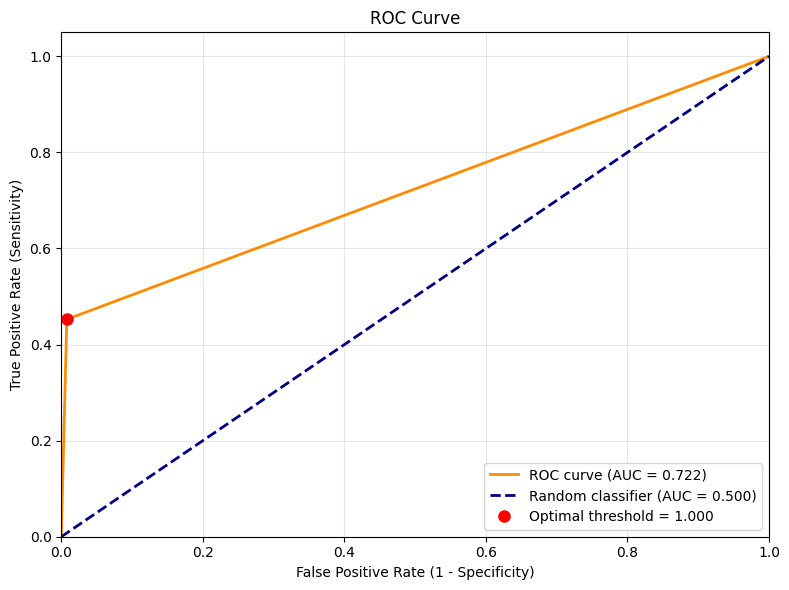

(0.7223376349265337, 1.0)

In [60]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve_binary(y_true, y_proba, title="ROC Curve", figsize=(8, 6)):

    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Création du plot
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier (AUC = 0.500)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Ajout du point optimal (Youden's J)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8,
             label=f'Optimal threshold = {optimal_threshold:.3f}')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc, optimal_threshold

plot_roc_curve_binary(y_test_class, y_pred_rf_class, title="ROC Curve", figsize=(8, 6))

c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c.mbimbiki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

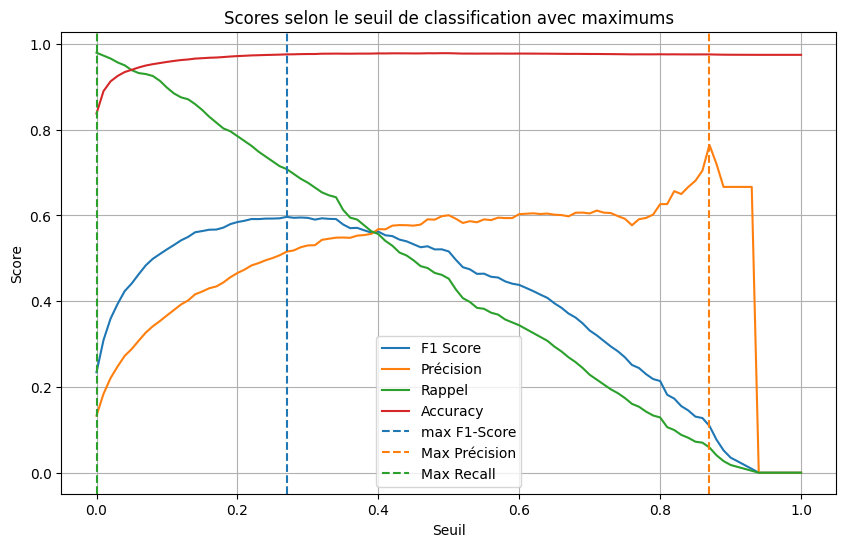

In [61]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_proba_rf_class = rf_model_class.predict_proba(X_test_class)[:, 1]
y_test = y_test_class

thresholds = np.linspace(0, 1, 101)

f1_scores = []
precisions = []
recalls = []
accuracies = []

for thresh in thresholds:
    y_pred = (y_proba_rf_class > thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Convertir en array pour faciliter la manipulation
f1_scores = np.array(f1_scores)
precisions = np.array(precisions)
recalls = np.array(recalls)
accuracies = np.array(accuracies)

# Trouver le premier maximum (le premier indice où la métrique atteint son max)
max_f1_idx = np.argmax(f1_scores)
max_precision_idx = np.argmax(precisions)
max_recall_idx = np.argmax(recalls)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Précision')
plt.plot(thresholds, recalls, label='Rappel')
plt.plot(thresholds, accuracies, label='Accuracy')

# Ajout des points en pointillés aux maximums
plt.axvline(x=thresholds[max_f1_idx], color='C0', label="max F1-Score", linestyle = '--')
plt.axvline(x=thresholds[max_precision_idx], color='C1', label="Max Précision", linestyle = '--')
plt.axvline(x=thresholds[max_recall_idx], color='C2', label="Max Recall", linestyle = '--')

plt.xlabel('Seuil')
plt.ylabel('Score')
plt.title('Scores selon le seuil de classification avec maximums')
plt.legend()
plt.grid(True)
plt.show()


Abandon d'un choix de seuil proche de la réalité des ventes car la classe BIG_ORDER est toujours trop petite pour une classification correcte, on passe par un quantile à 98% à la place. 

In [62]:
df_categorical2=df.copy()

threshold=df_categorical2['VENTES'].quantile(0.98)

df_categorical2["big_orders"]=df_categorical2["VENTES"]>threshold
df_categorical2.head()

,CODE_ARTICLE,STOCK_INITIAL,REGULATIONS,RETARDES,BESOINS_PREVISIONNELS,MOIS,DELAI_DE_TRANSIT,VENTES,VENTES_PREDITES,future,...,COUNTRY_CATEGORY_Large,COUNTRY_CATEGORY_VeryLarge,CLIENT_CATEGORY_Medium,CLIENT_CATEGORY_Large,CLIENT_CATEGORY_VeryLarge,SYMPTOM_CATEGORY_Medium,SYMPTOM_CATEGORY_Large,SYMPTOM_CATEGORY_VeryLarge,MONTH,big_orders
3752,AC1-400-MA,0,0,0,0,1,21,0,0.0,0,...,True,False,False,False,False,True,False,False,1,False
3755,AC1-400-MA,0,0,0,0,2,21,0,0.0,0,...,True,False,False,False,False,True,False,False,2,False
3760,AC1-400-MA,0,0,0,0,3,21,0,0.0,0,...,True,False,False,False,False,True,False,False,3,False
3761,AC1-400-MA,0,0,0,0,4,21,0,0.0,0,...,True,False,False,False,False,True,False,False,4,False
3765,AC1-400-MA,0,0,0,0,5,21,0,0.0,0,...,True,False,False,False,False,True,False,False,5,False


In [63]:
X = df_categorical2.drop(columns=['VENTES','CODE_ARTICLE'])
y = df_categorical2['VENTES']

train_mask = df_categorical2['year'] < 2023
test_mask = df_categorical2['year'] >= 2023

X_train = X[train_mask].drop(columns=['VENTES_PREDITES'])
X_test = X[test_mask].drop(columns=['VENTES_PREDITES'])
y_train = y[train_mask]
y_test = y[test_mask]
forecast_train = X[train_mask]['VENTES_PREDITES']
forecast_test = X[test_mask]['VENTES_PREDITES']

X_test=X_test.drop(["big_orders"], axis=1)
X_test["big_orders"]=y_pred_rf_class

In [64]:
##############################################Linear Regression model ##########################################################
lin_model=LinearRegression()
lin_model.fit(X_train, y_train)


y_pred_lin=pd.Series(lin_model.predict(X_test), index=y_test.index)
y_pred_linT=pd.Series(lin_model.predict(X_train), index=y_train.index)

# Evaluation des performances sur le sous-ensemble test
rmse_lin=np.sqrt(mean_squared_error(y_test, y_pred_lin))
mae_lin=mean_absolute_error(y_test, y_pred_lin)
r2_lin=r2_score(y_test, y_pred_lin)

# Evaluation des performances sur le sous-ensemble train
rmse_linT=np.sqrt(mean_squared_error(y_train, y_pred_linT))
mae_linT=mean_absolute_error(y_train, y_pred_linT)
r2_linT=r2_score(y_train, y_pred_linT)

##############################################Lasso Regression model ##########################################################

lasso_model=best_models['Lasso']['model']
lasso_model.fit(X_train, y_train)

y_pred_lasso=pd.Series(lasso_model.predict(X_test), index=y_test.index)
y_pred_lassoT=pd.Series(lasso_model.predict(X_train), index=y_train.index)

rmse_lasso=np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso=mean_absolute_error(y_test, y_pred_lasso)
r2_lasso=r2_score(y_test, y_pred_lasso)

rmse_lassoT=np.sqrt(mean_squared_error(y_train, y_pred_lassoT))
mae_lassoT=mean_absolute_error(y_train, y_pred_lassoT)
r2_lassoT=r2_score(y_train, y_pred_lassoT)


##############################################Ridge Regression model ##########################################################

ridge_model=best_models['Ridge']['model']
ridge_model.fit(X_train, y_train)

y_pred_ridge=pd.Series(ridge_model.predict(X_test), index=y_test.index)
y_pred_ridgeT=pd.Series(ridge_model.predict(X_train), index=y_train.index)

rmse_ridge=np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge=mean_absolute_error(y_test, y_pred_ridge)
r2_ridge=r2_score(y_test, y_pred_ridge)

rmse_ridgeT=np.sqrt(mean_squared_error(y_train, y_pred_ridgeT))
mae_ridgeT=mean_absolute_error(y_train, y_pred_ridgeT)
r2_ridgeT=r2_score(y_train, y_pred_ridgeT)

##############################################Prédictions manuelles##########################################################


rmse_fm=np.sqrt(mean_squared_error(y_test, forecast_test))
mae_fm=mean_absolute_error(y_test, forecast_test)
r2_fm=r2_score(y_test, forecast_test) 


rmse_fmT=np.sqrt(mean_squared_error(y_train, forecast_train))
mae_fmT=mean_absolute_error(y_train, forecast_train)
r2_fmT=r2_score(y_train, forecast_train) 

#Collecte des métriques de performance pour l'affichage (test)
performance_metricsR={
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Forecast Manuel'],
    'RMSE': [rmse_lin, rmse_ridge, rmse_lasso, rmse_fm],
    'MAE': [mae_lin, mae_ridge, mae_lasso, mae_fm],
    'R2': [r2_lin, r2_ridge, r2_lasso, r2_fm],
}

# Collecte des métriques de performance pour l'affichage (train)
performance_metricsTR={
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Forecast Manuel'],
    'RMSE': [rmse_linT, rmse_ridgeT, rmse_lassoT, rmse_fmT],
    'MAE': [mae_linT, mae_ridgeT, mae_lassoT, mae_fmT],
    'R2': [r2_linT, r2_ridgeT, r2_lassoT, r2_fmT],
}

performance_dfR=pd.DataFrame(performance_metricsR)
performance_dfTR=pd.DataFrame(performance_metricsTR)

print("\n=== Métriques sur les données de test ===")
print(performance_dfR)
print("\n=== Métriques sur les données de train ===")
print(performance_dfTR)



=== Métriques sur les données de test ===
               Model         RMSE         MAE        R2
0  Linear Regression  1163.011417  433.219926  0.082293
1   Ridge Regression  1149.936615  426.606244  0.102811
2   Lasso Regression  1170.901041  426.820018  0.069799
3    Forecast Manuel  1072.607831  335.187643  0.219419

=== Métriques sur les données de train ===
               Model         RMSE         MAE        R2
0  Linear Regression   785.409557  290.388183  0.626183
1   Ridge Regression   794.449468  286.717456  0.617528
2   Lasso Regression   794.724643  284.160697  0.617263
3    Forecast Manuel  1090.622901  222.703100  0.279198


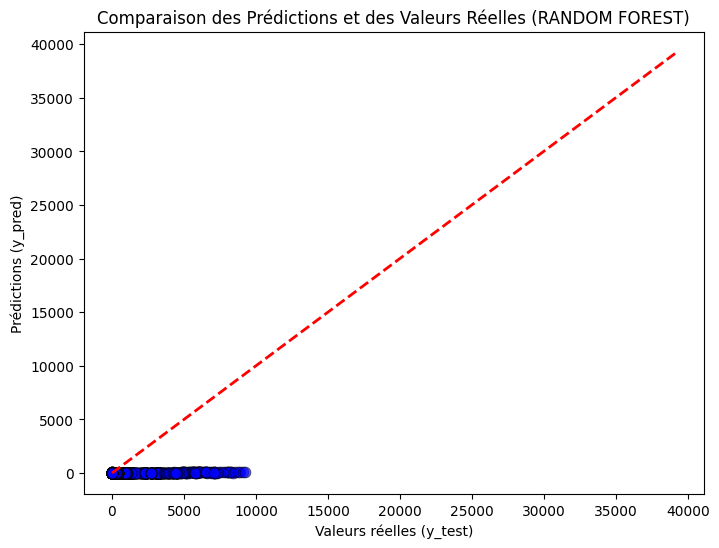

In [65]:
# Création du scatter plot
plt.figure(figsize=(8, 6))  # Taille du graphique

# Nuage de points des prédictions vs valeurs réelles
sns.scatterplot(x=y_test, y=y_pred_rf, color='blue', s=60, alpha=0.6, edgecolor='k')

# Ligne de référence (prédictions parfaites)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')

# Titres et légendes
plt.xlabel('Valeurs réelles (y_test)')
plt.ylabel('Prédictions (y_pred)')
plt.title('Comparaison des Prédictions et des Valeurs Réelles (RANDOM FOREST)')

plt.show()

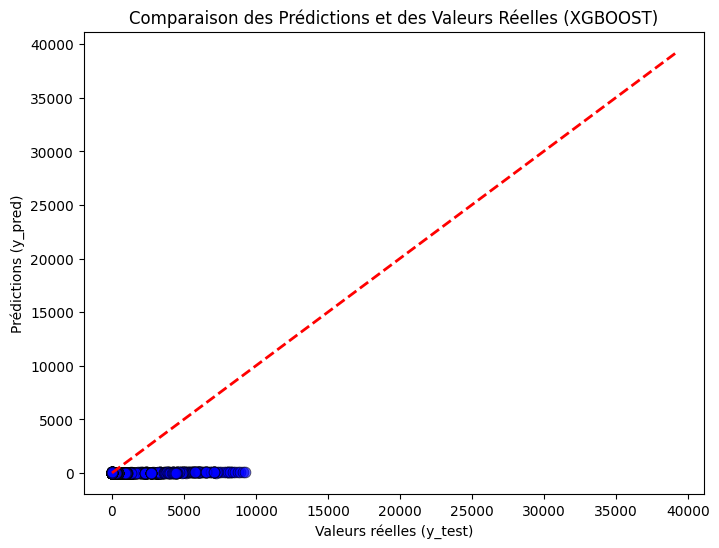

In [66]:
# Création du scatter plot
plt.figure(figsize=(8, 6))  # Taille du graphique

# Nuage de points des prédictions vs valeurs réelles
sns.scatterplot(x=y_test, y=y_pred_xg, color='blue', s=60, alpha=0.6, edgecolor='k')

# Ligne de référence (prédictions parfaites)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')

# Titres et légendes
plt.xlabel('Valeurs réelles (y_test)')
plt.ylabel('Prédictions (y_pred)')
plt.title('Comparaison des Prédictions et des Valeurs Réelles (XGBOOST)')

plt.show()

Ayant introduit un saut artificiel qui n'apparaît pas dans les observations réels ce biais se reflète dans les prédictions et elles n'ont donc pas du tout l'allure attendue.